In [1]:
from functools import partial

import numpy as np

np.set_printoptions(precision=3, suppress=True)

import matplotlib.pyplot as plt

import jax
from jax.flatten_util import ravel_pytree
from jax import numpy as jnp, random as jr, value_and_grad, tree_util

import optax

from env import Env
from svae.inference import make_gradfun
from svae.utils import split_into_batches, flat
from network import init_mlp, identity, make_loglike
from hmm import run_inference, init_pgm_param, rollout, onehot_sample, gumbel_softmax

In [2]:
key = jr.PRNGKey(123)
batch_dim = 64
num_epochs, num_samples, num_steps = 2000, 5000, 8

env = Env()

data_key, key = jr.split(key)
data, actions = env.sample(data_key, num_samples, num_steps)
data = data.reshape(num_samples, num_steps, -1)

batch_key, key = jr.split(key)
(data_batches, action_batches), num_batches = split_into_batches(batch_key, (data, actions), batch_dim)
get_batch = lambda i: data_batches[i % num_batches]
get_action_batch = lambda i: action_batches[i % num_batches]

In [3]:
def test(params, data, actions, env, key):
    infer_key, key = jr.split(key)
    pgm_params, decoder_params, encoder_params = params

    idx = np.random.randint(data.shape[0])
    test_data = data[idx : idx + 1, :]
    test_actions = actions[idx : idx + 1, :]

    node_potentials = encoder(encoder_params, test_data)
    samples, _, _, _ = run_inference(infer_key, pgm_prior_params, pgm_params, node_potentials, 1, test_actions)
    decoded = decoder(decoder_params, samples)

    test_data_0, test_actions = test_data[0, 0, :], test_actions[0, :]
    node_potential_0 = encoder(encoder_params, test_data_0)
    logits = rollout(pgm_params, node_potential_0, test_actions)

    sample_key, key = jr.split(key)
    samples = onehot_sample(logits, sample_key)
    decoded_rollout = decoder(decoder_params, samples)

    env.plot_sample(test_data.reshape(-1, 10, 10), test_actions)
    env.plot_sample(decoded.reshape(-1, 10, 10))
    env.plot_sample(decoded_rollout.reshape(-1, 10, 10))

    probs = pgm_params[1] / jnp.sum(pgm_params[1], axis=-1, keepdims=True)
    fig, axs = plt.subplots(1, 4)
    for i in range(4):
        axs[i].imshow(probs[i])
        axs[i].axis("off")
    plt.show()

epoch 0: 554.52


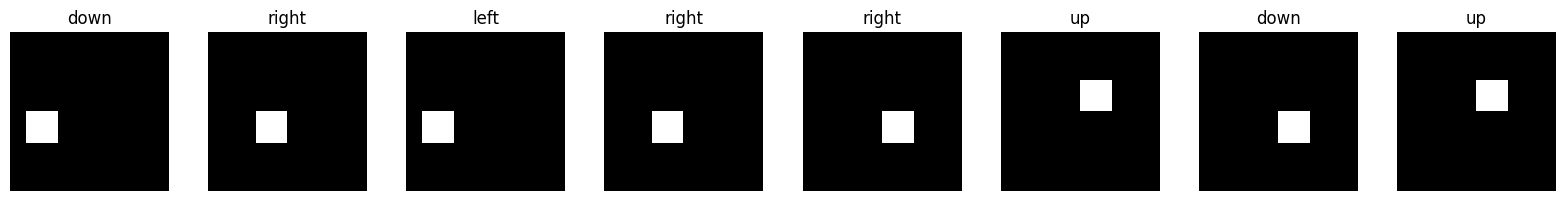

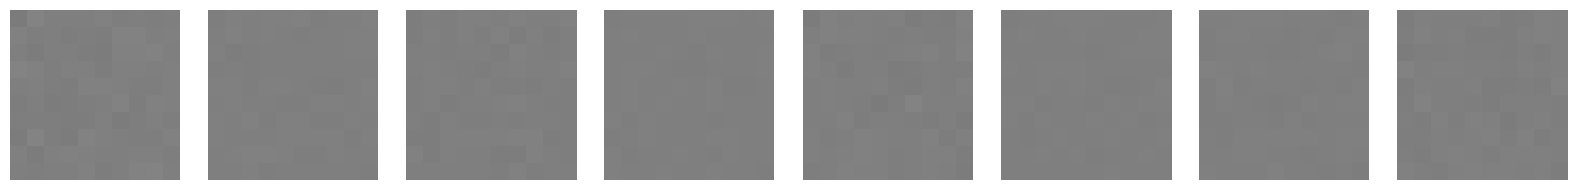

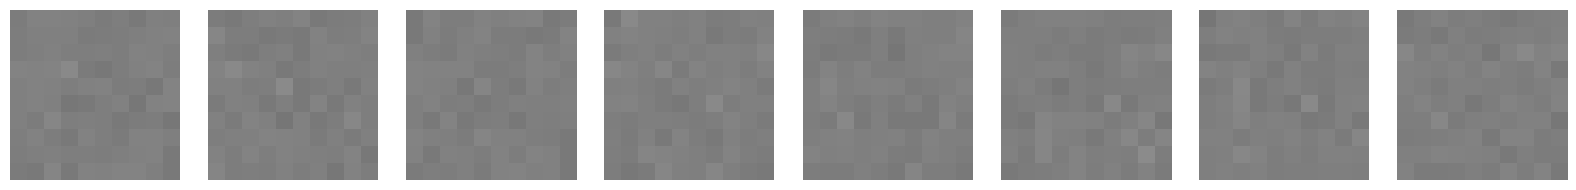

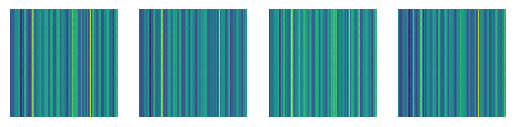

epoch 100: 122.11


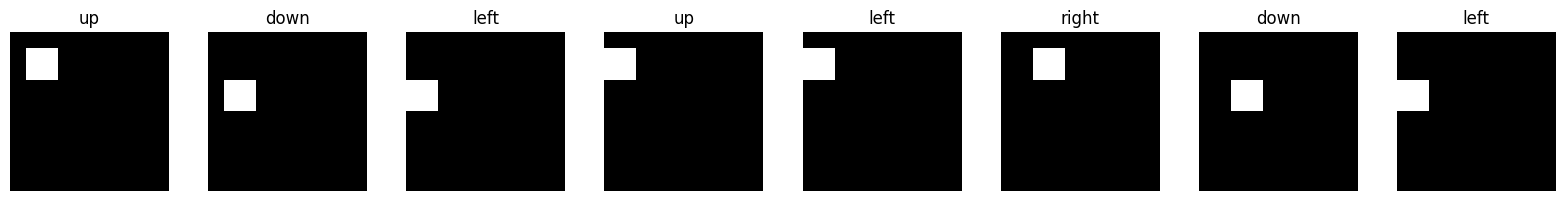

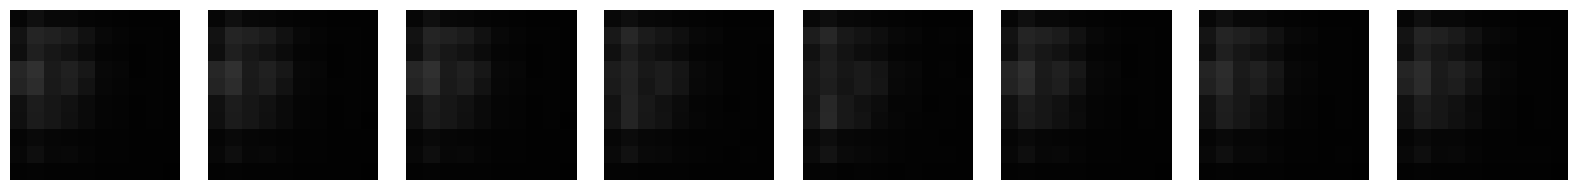

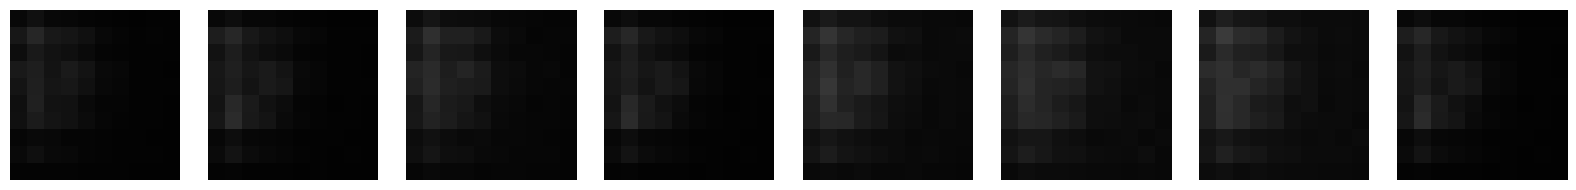

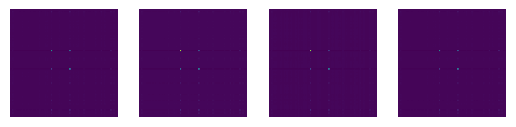

epoch 200: 91.26


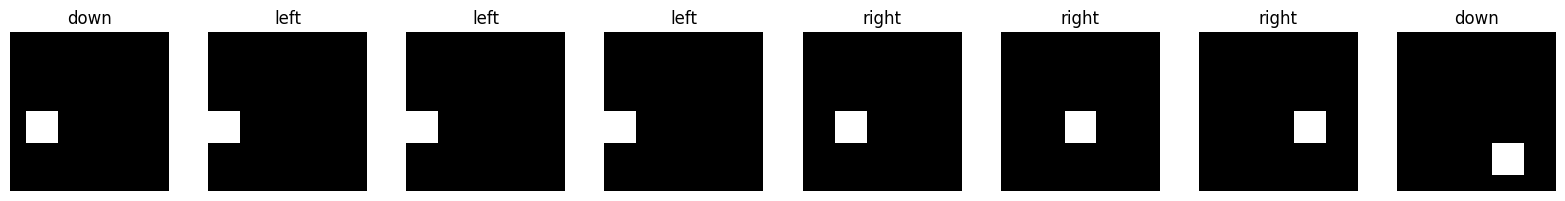

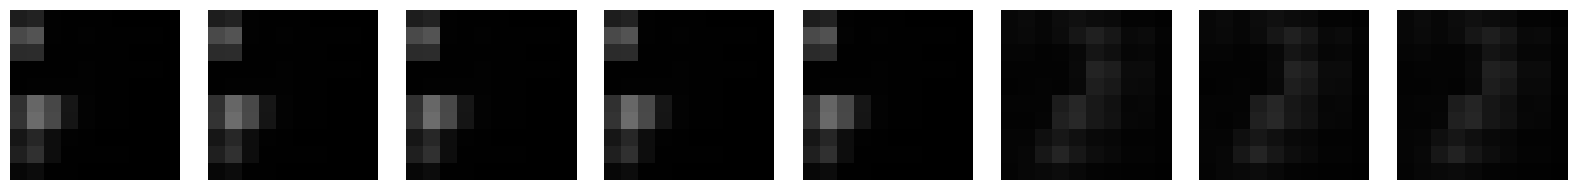

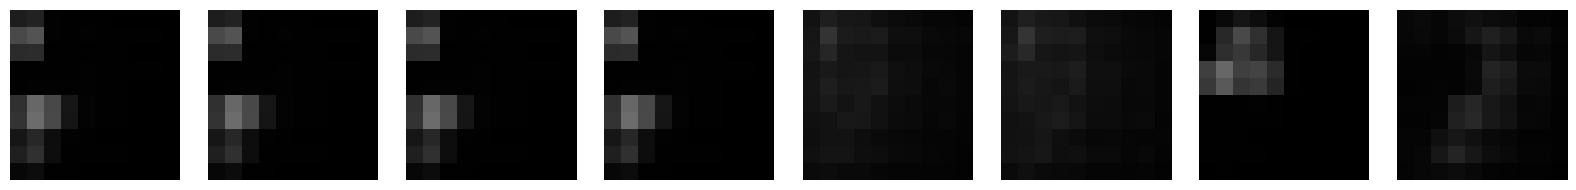

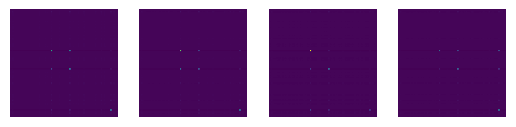

epoch 300: 89.94


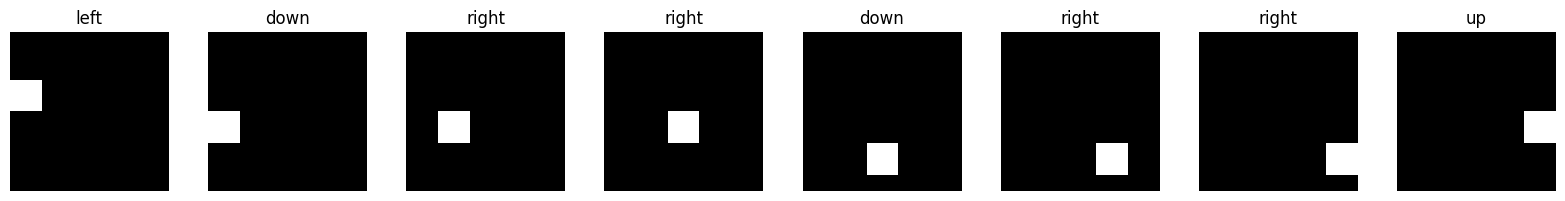

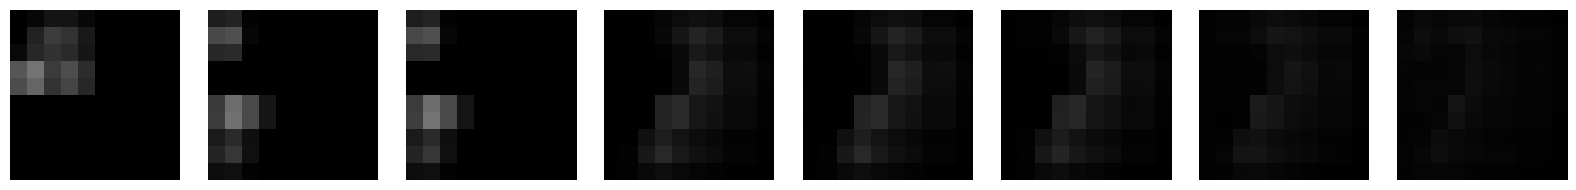

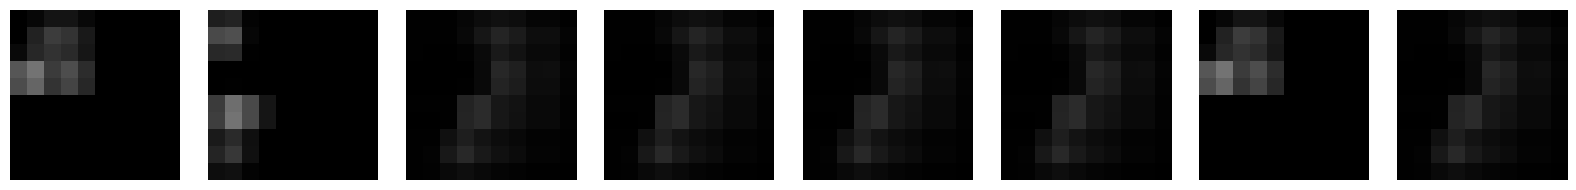

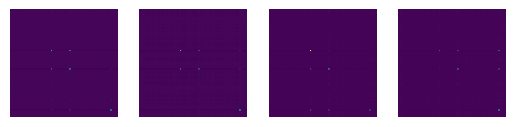

epoch 400: 88.96


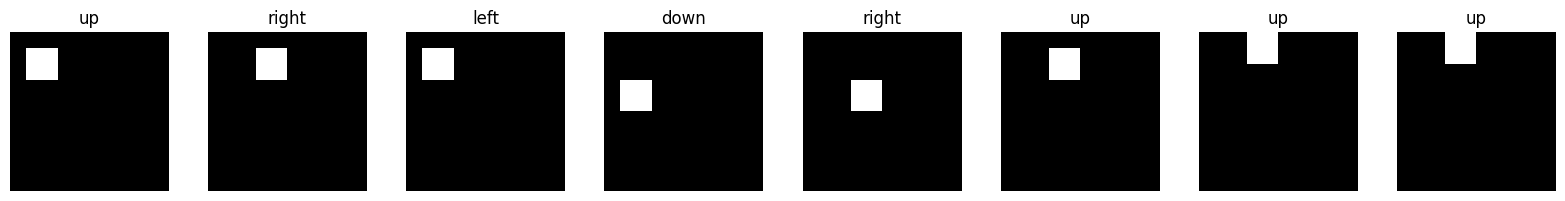

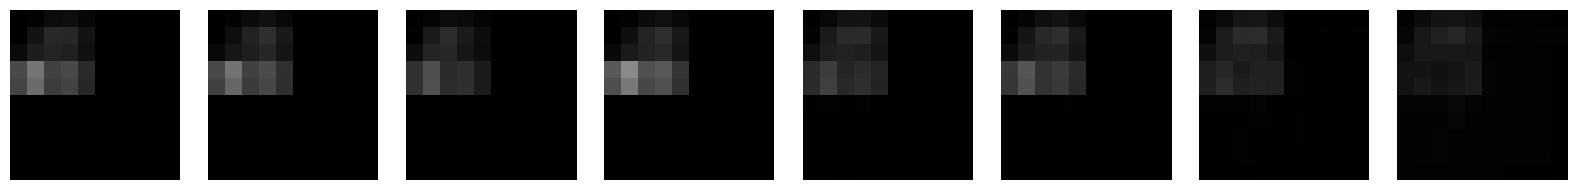

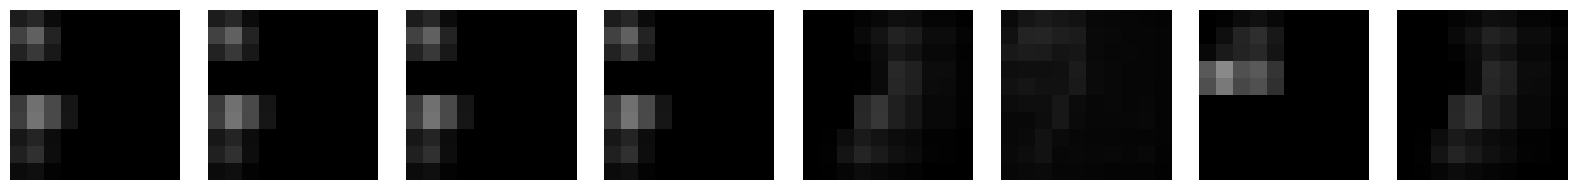

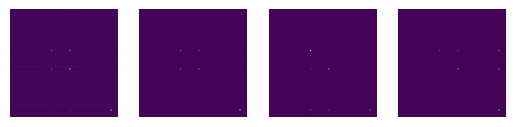

epoch 500: 73.93


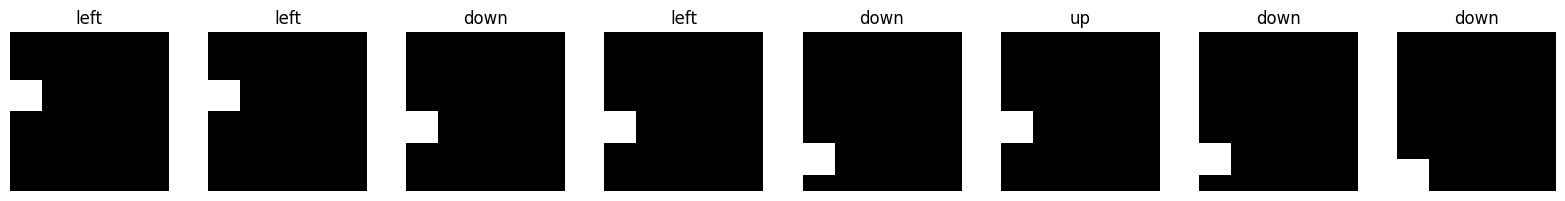

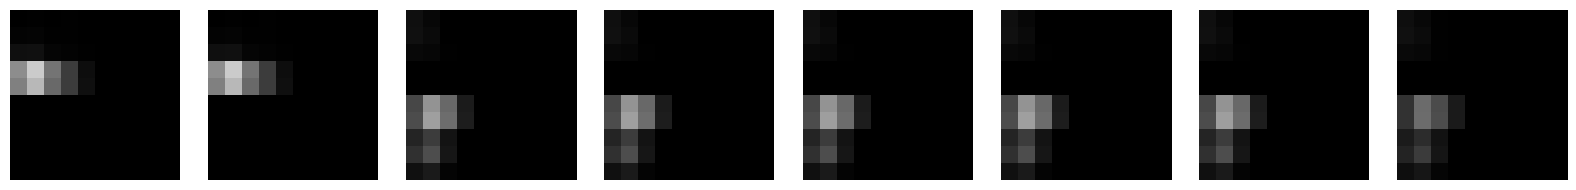

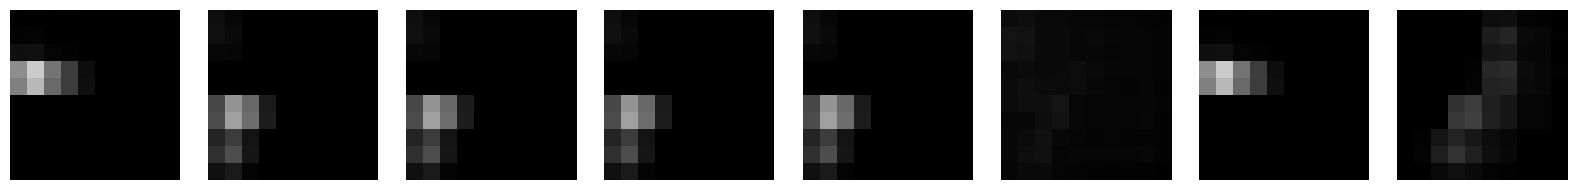

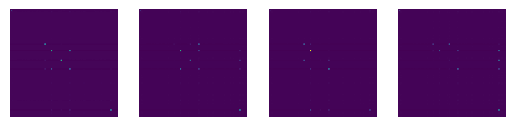

epoch 600: 65.67


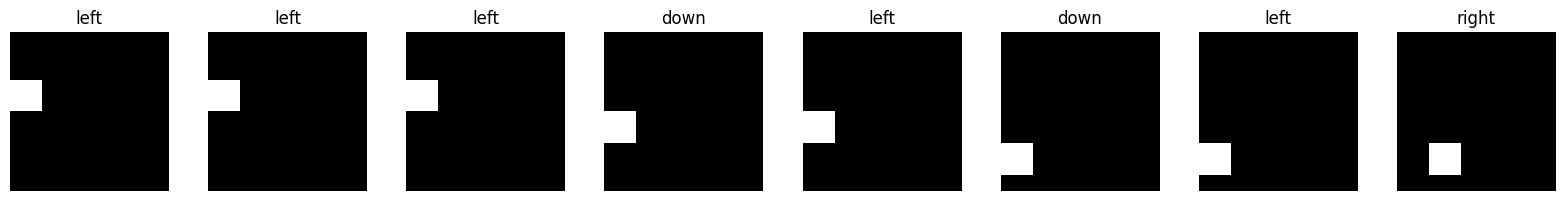

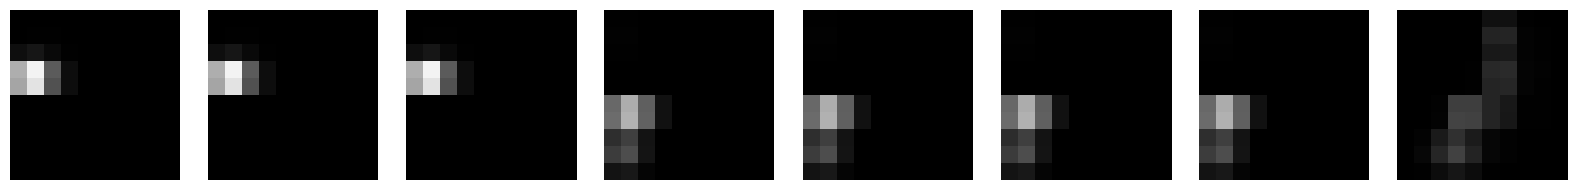

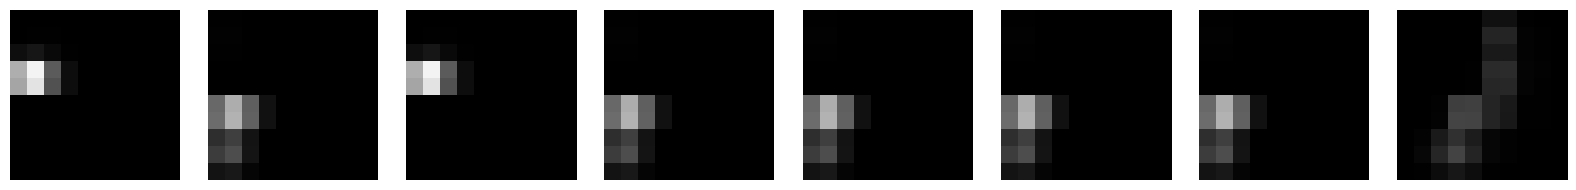

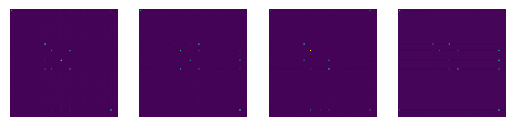

epoch 700: 61.29


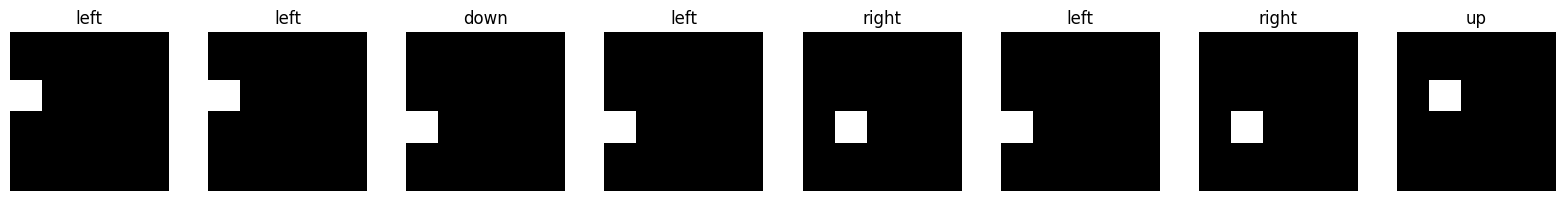

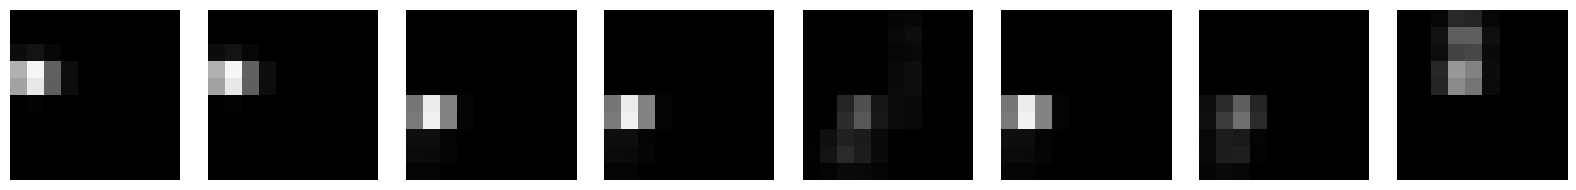

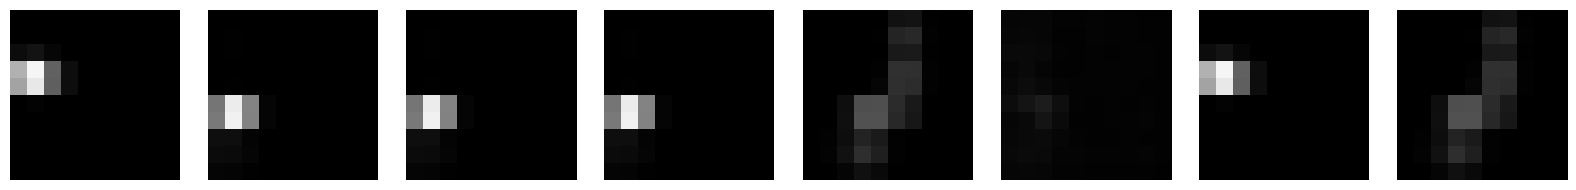

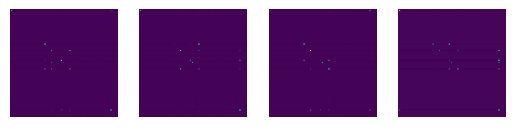

epoch 800: 53.09


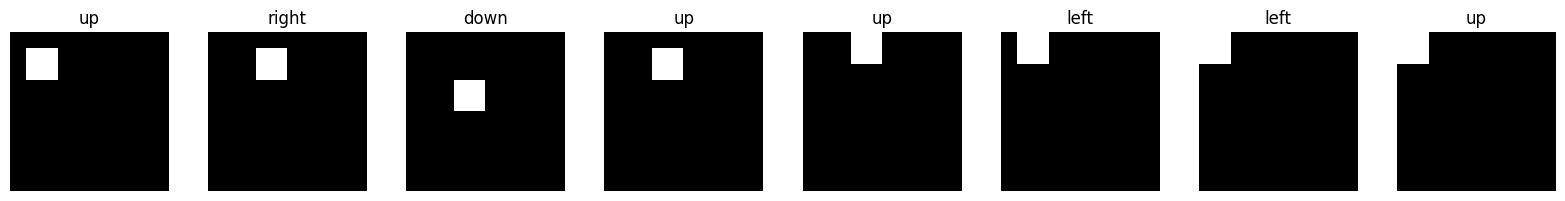

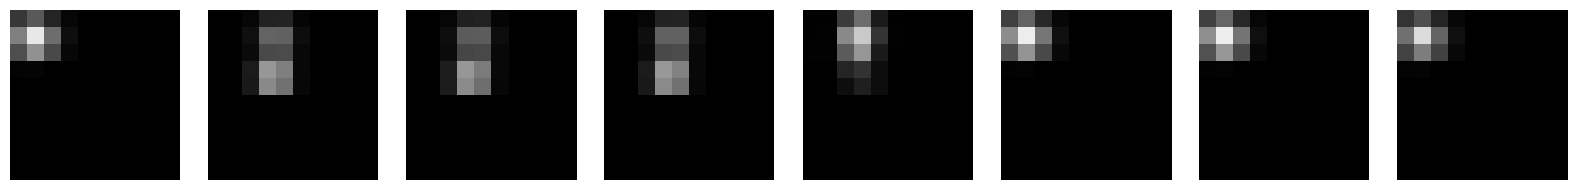

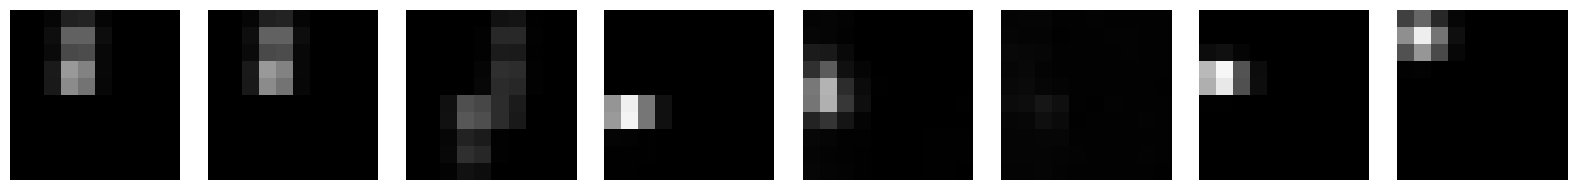

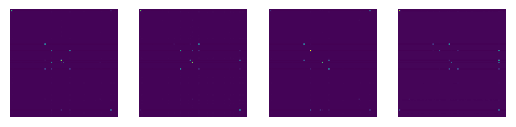

epoch 900: 55.03


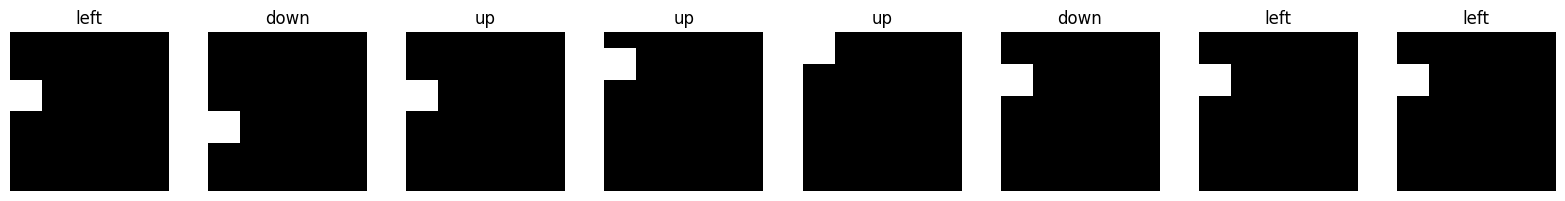

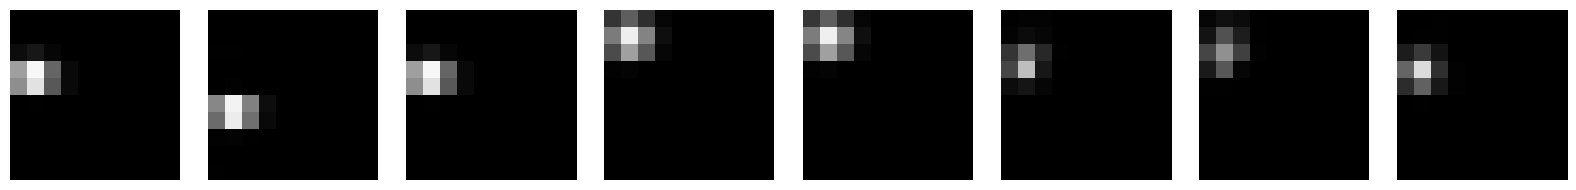

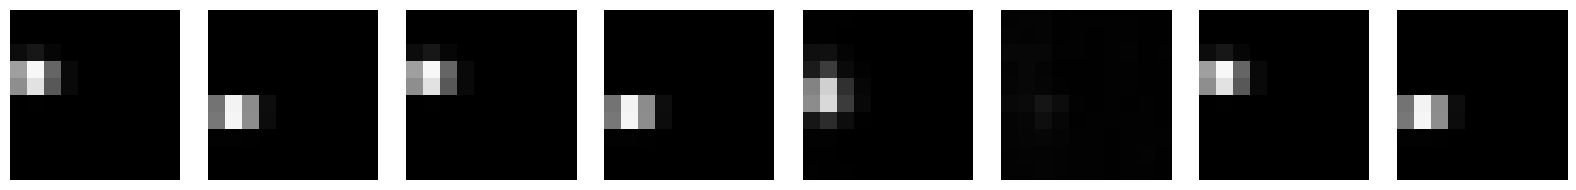

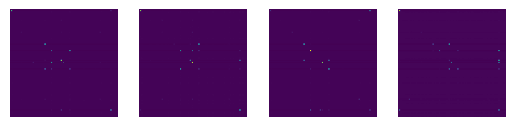

epoch 1000: 53.52


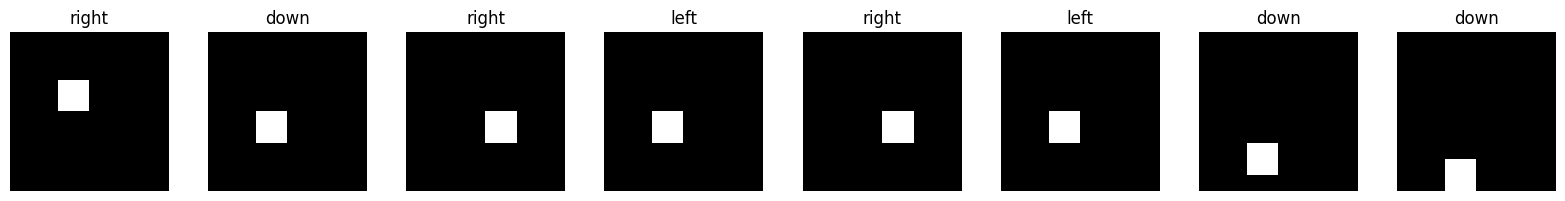

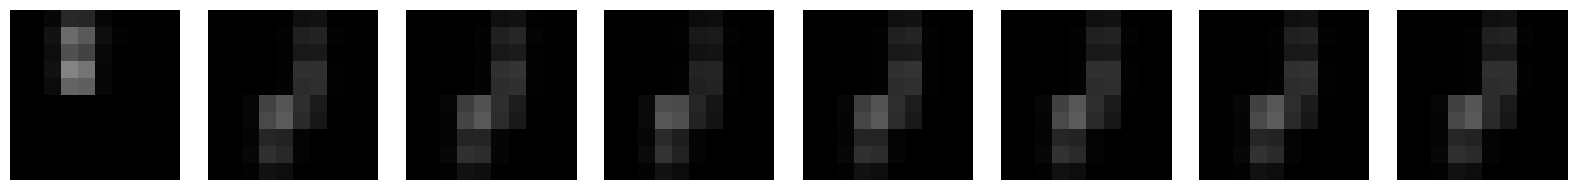

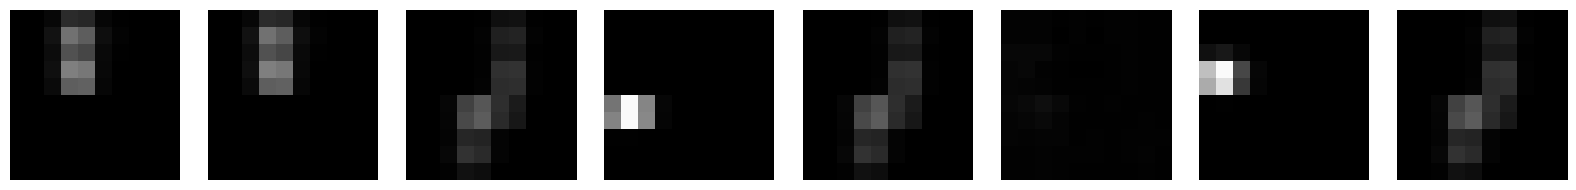

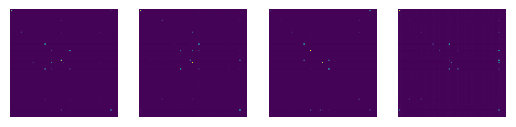

epoch 1100: 44.19


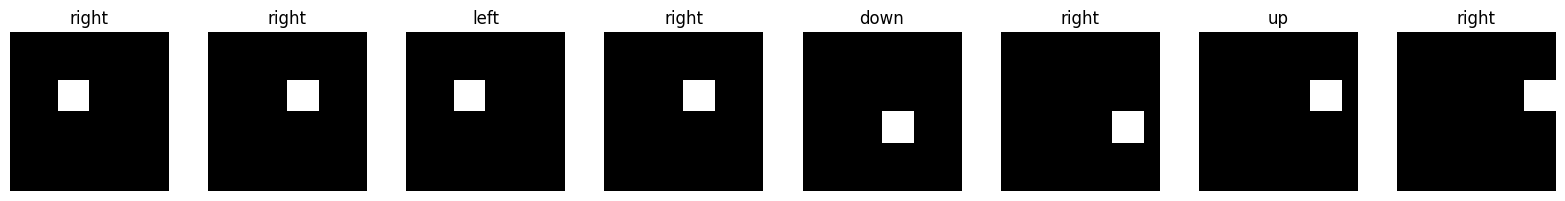

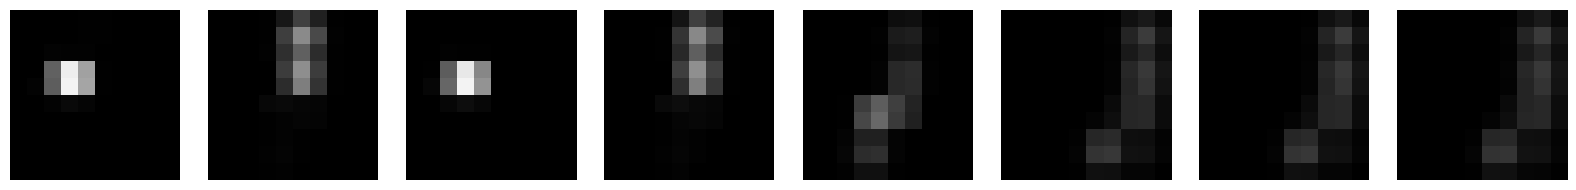

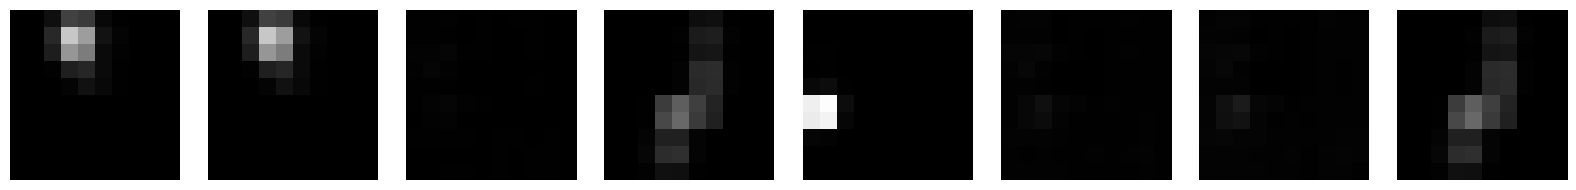

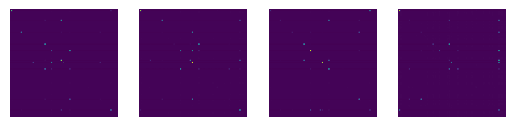

epoch 1200: 43.22


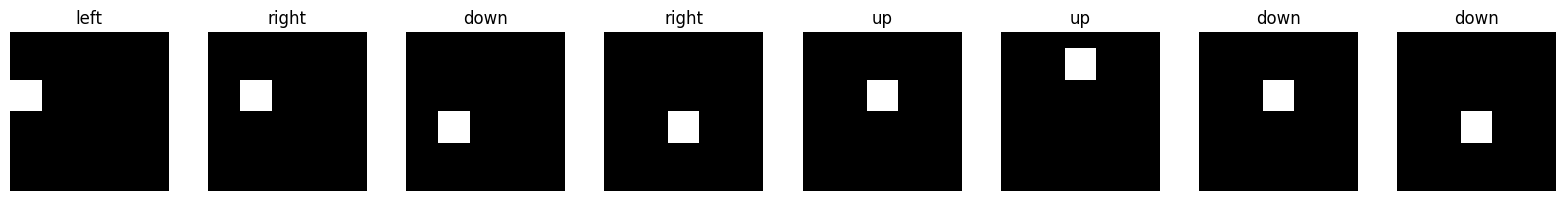

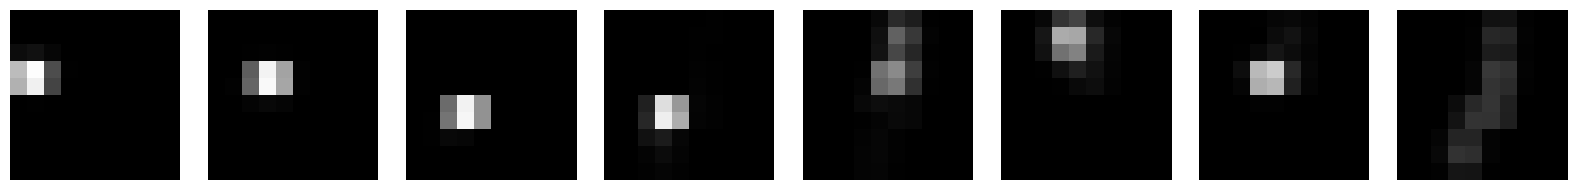

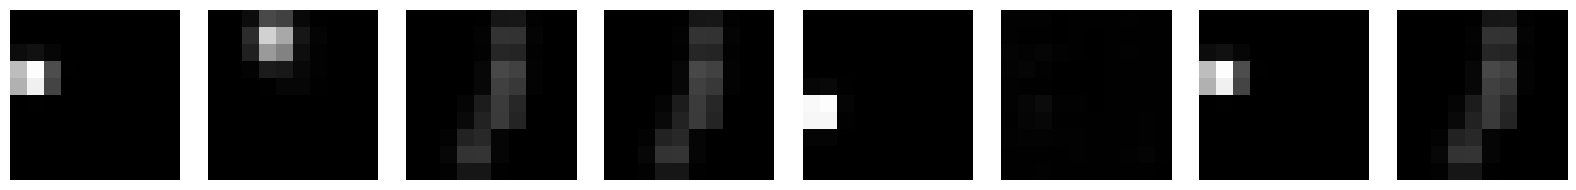

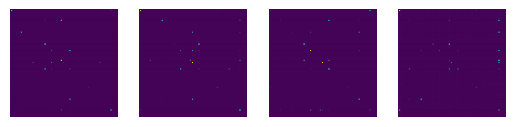

epoch 1300: 46.87


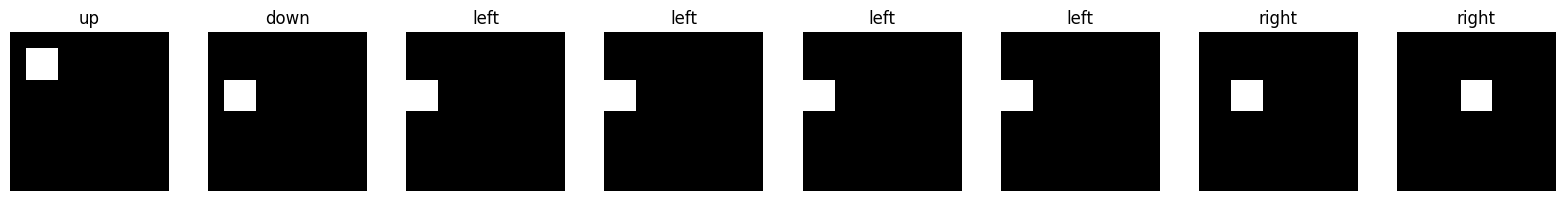

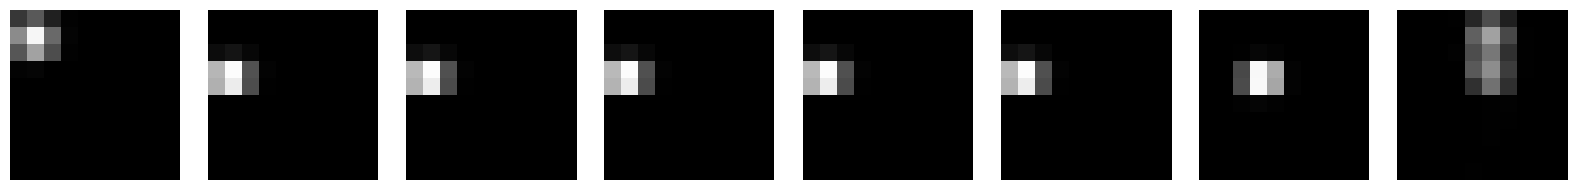

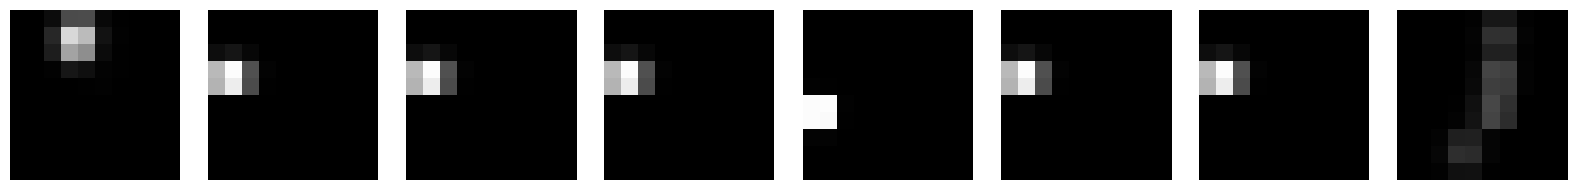

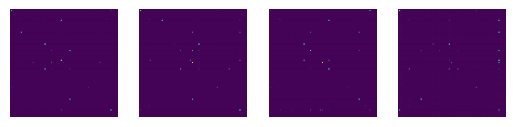

epoch 1400: 38.28


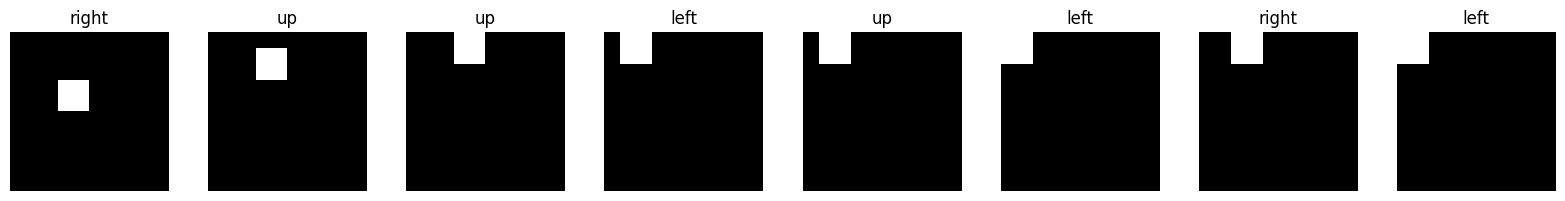

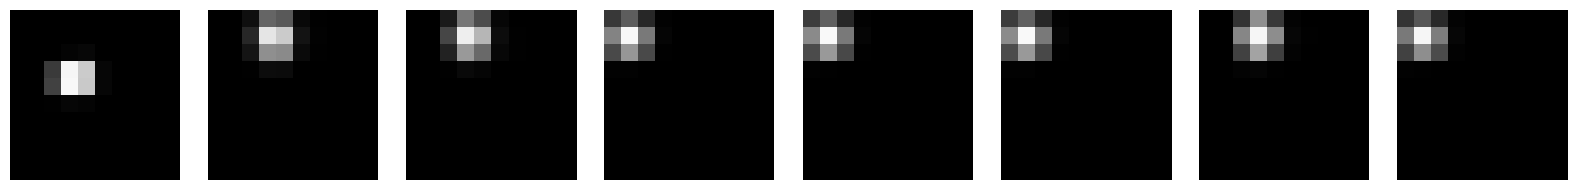

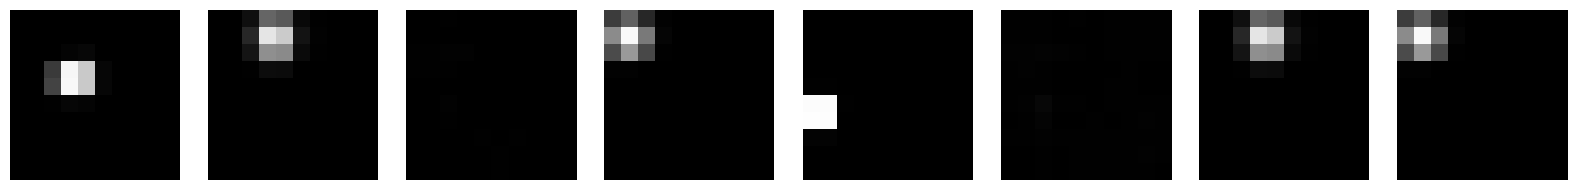

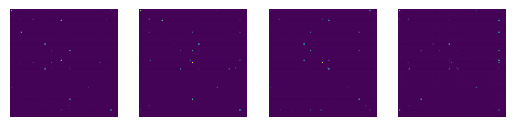

epoch 1500: 38.06


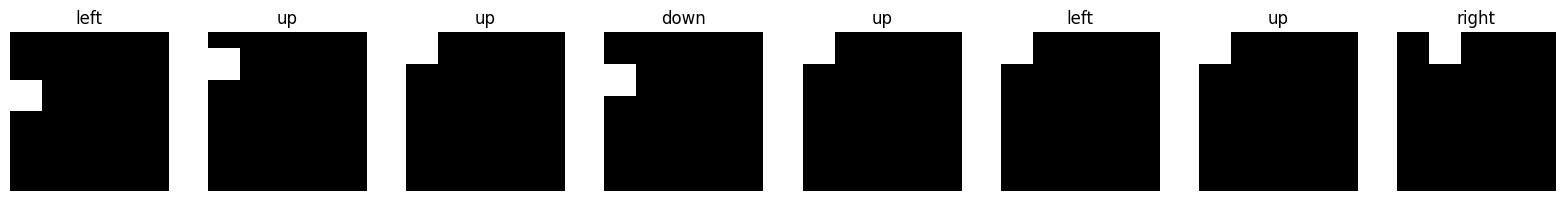

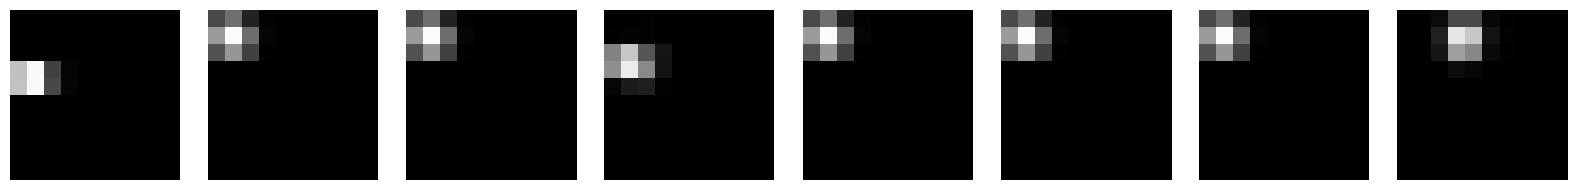

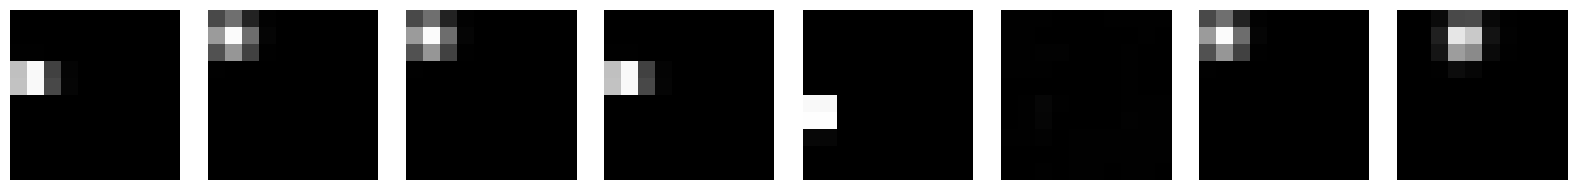

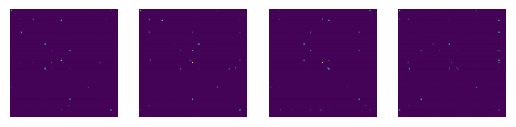

epoch 1600: 33.66


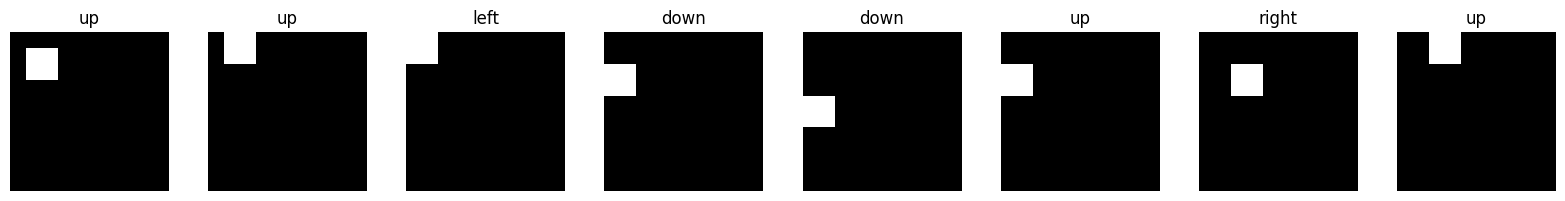

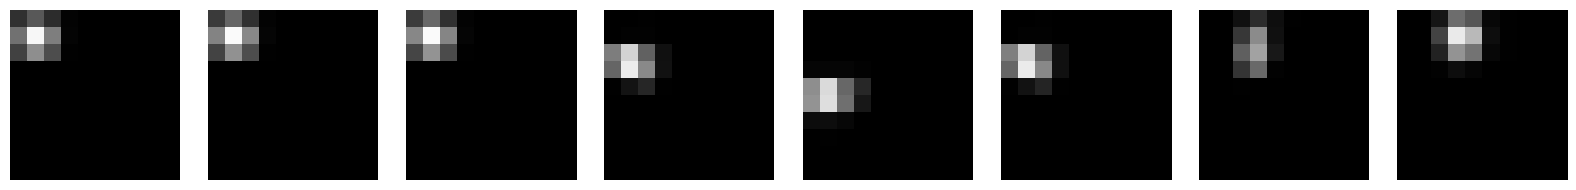

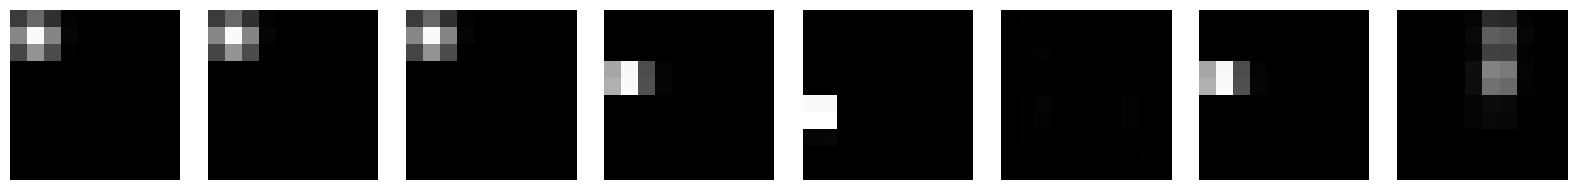

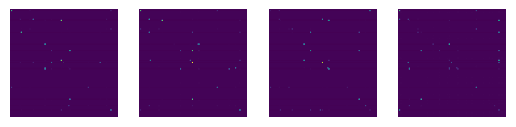

epoch 1700: 35.04


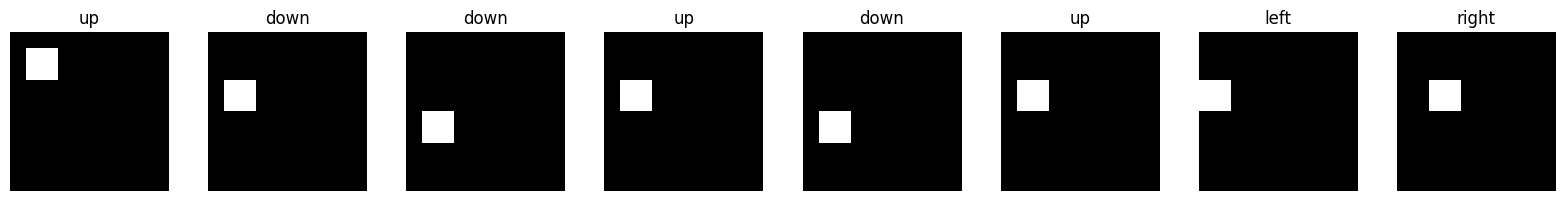

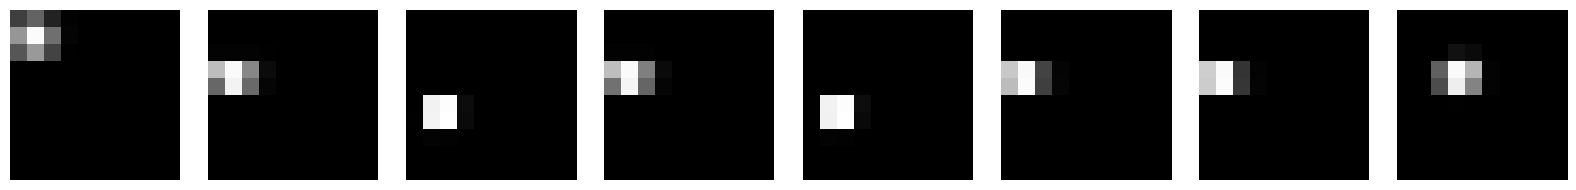

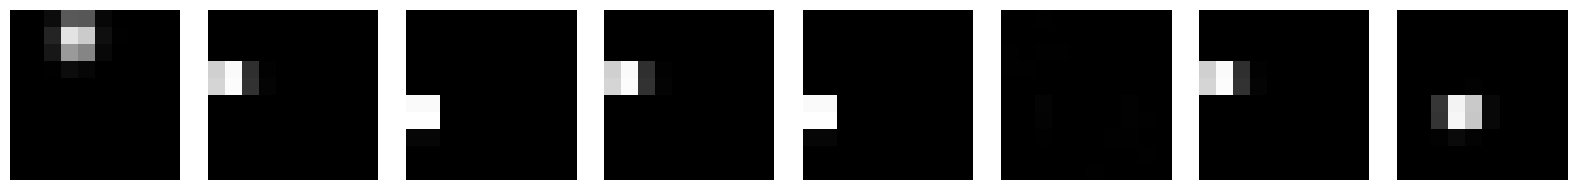

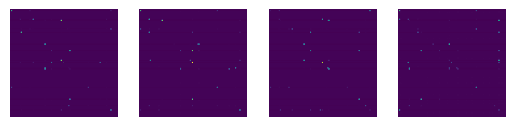

epoch 1800: 34.99


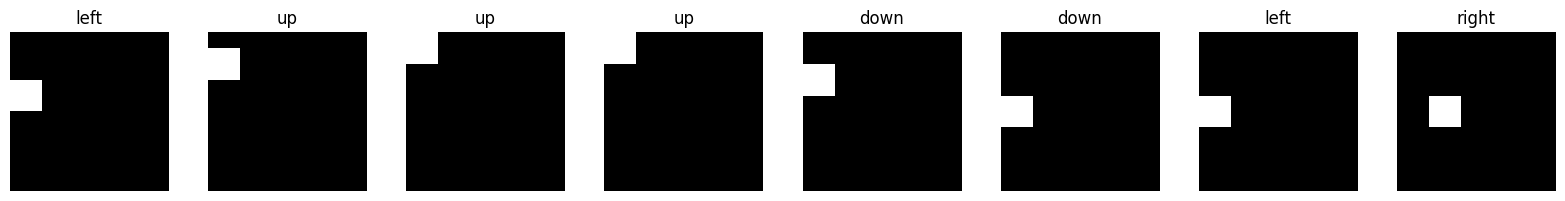

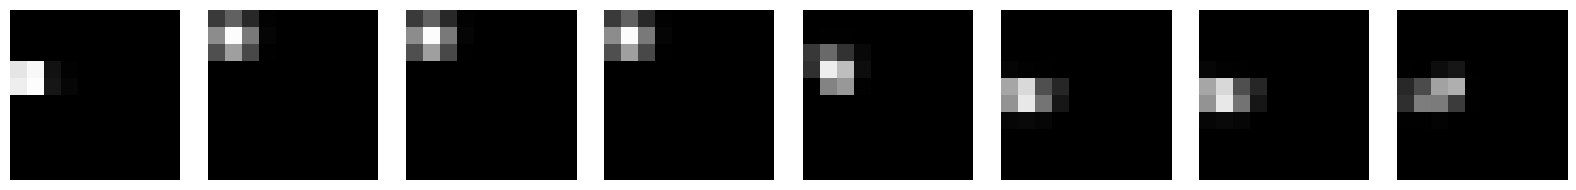

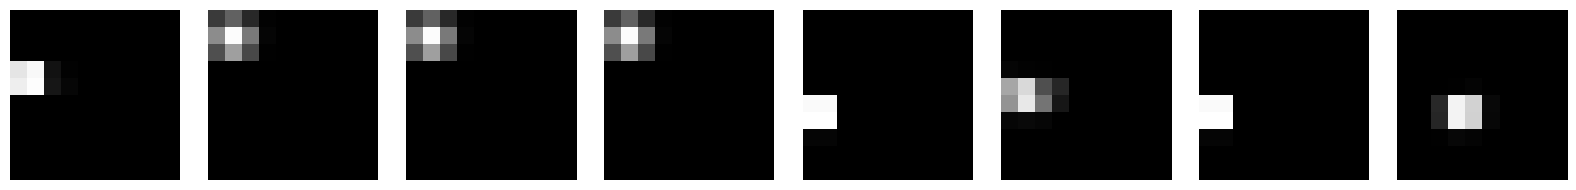

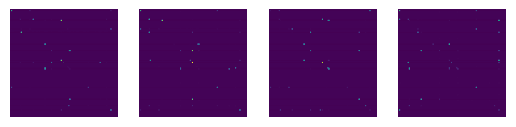

epoch 1900: 30.04


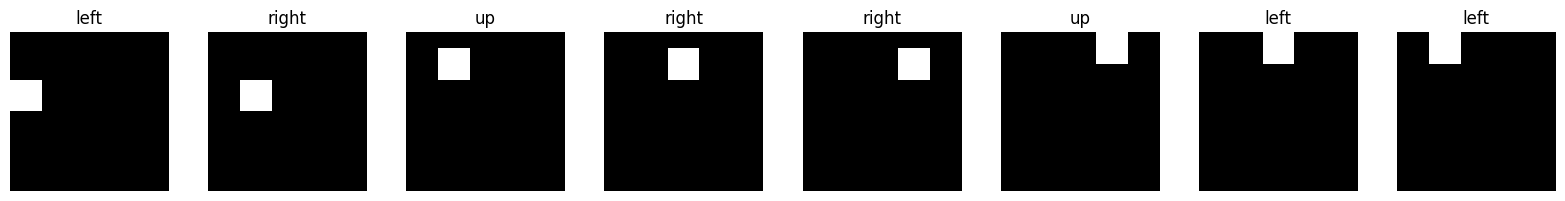

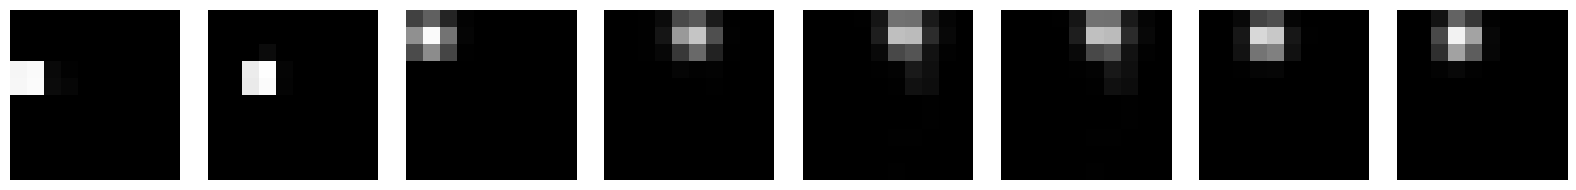

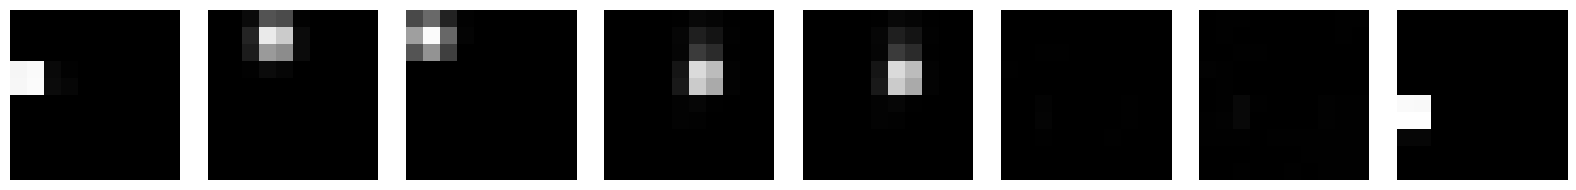

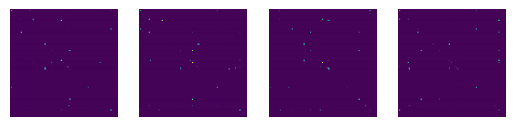

epoch 2000: 29.21


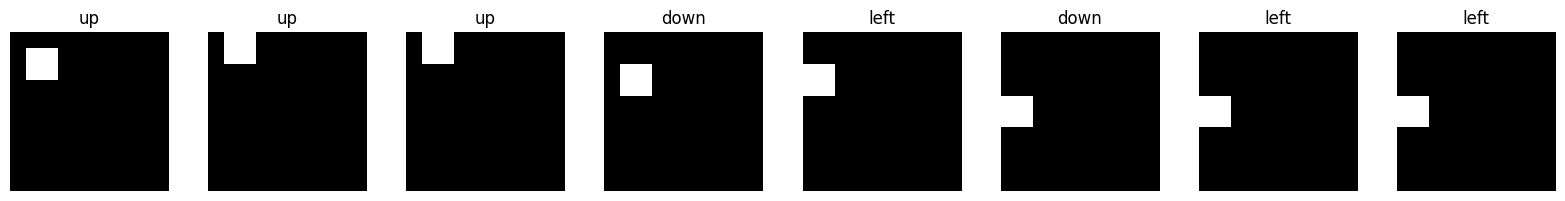

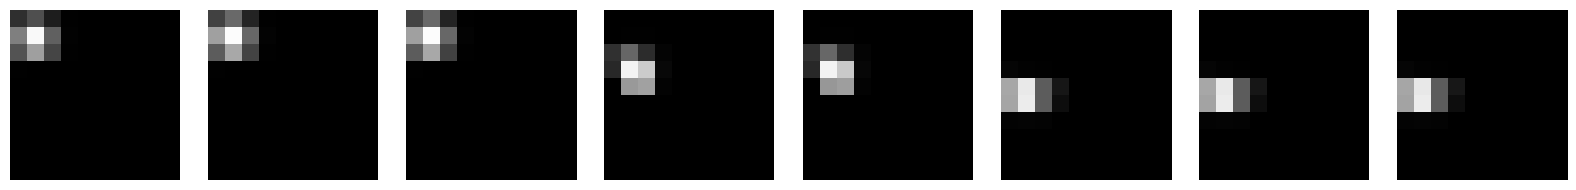

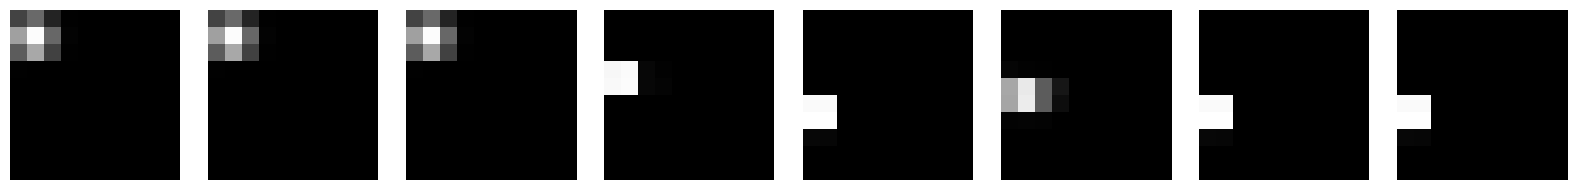

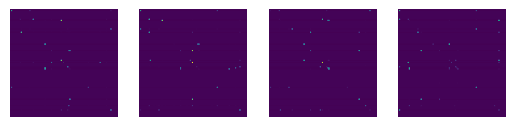

epoch 2100: 25.18


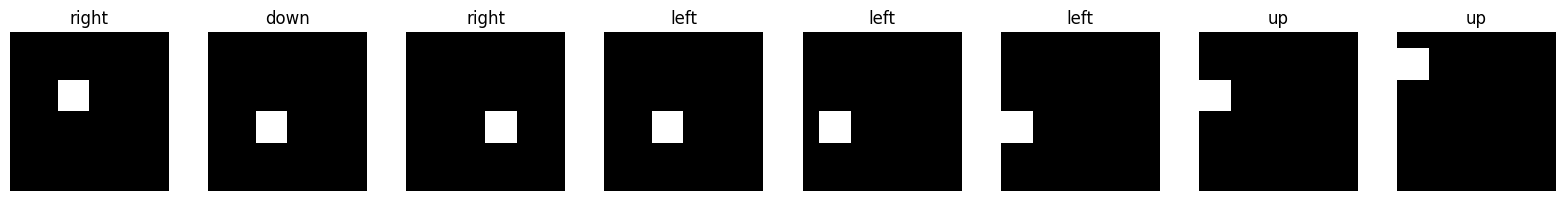

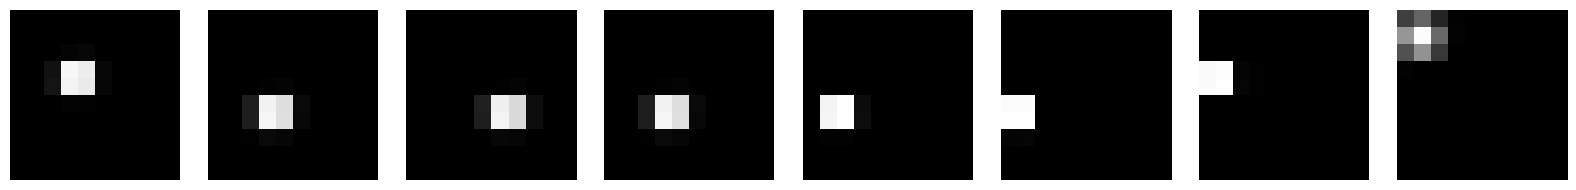

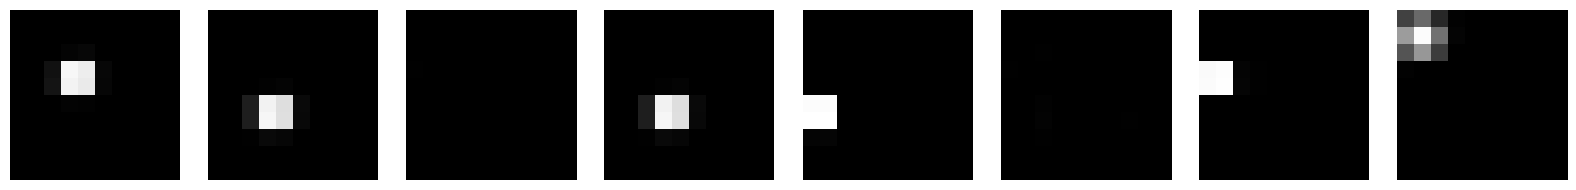

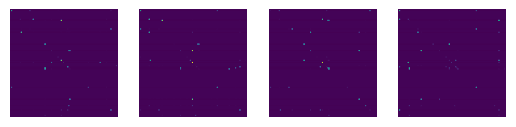

epoch 2200: 26.26


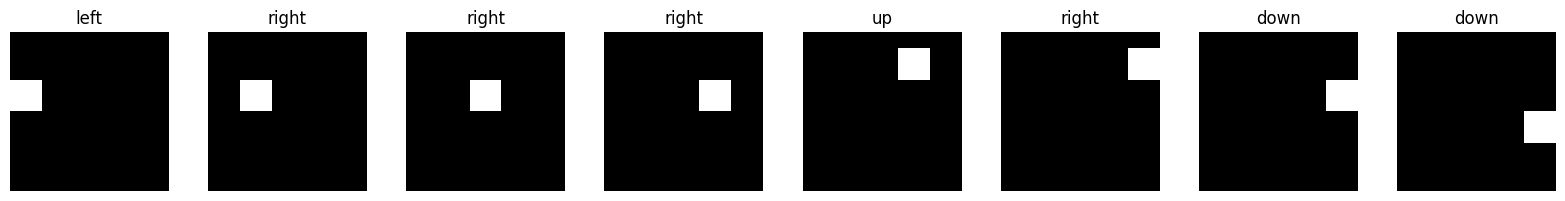

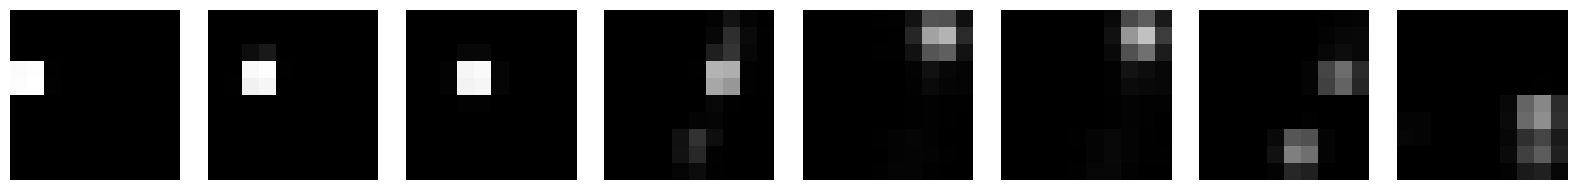

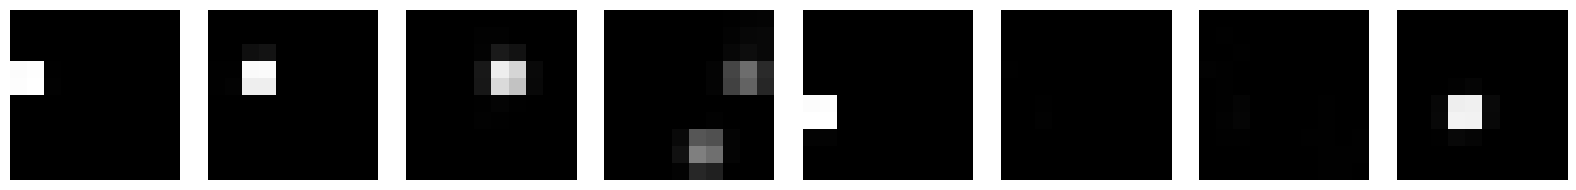

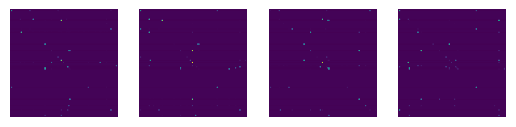

epoch 2300: 27.36


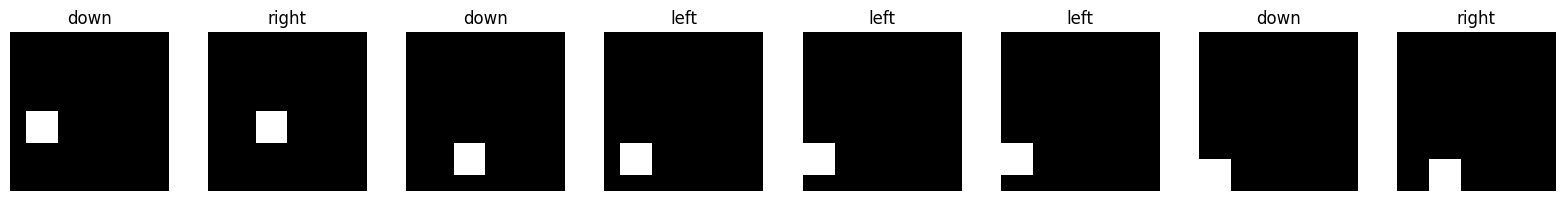

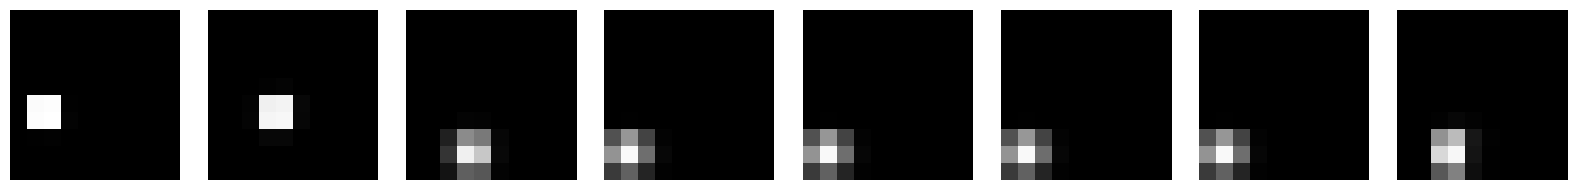

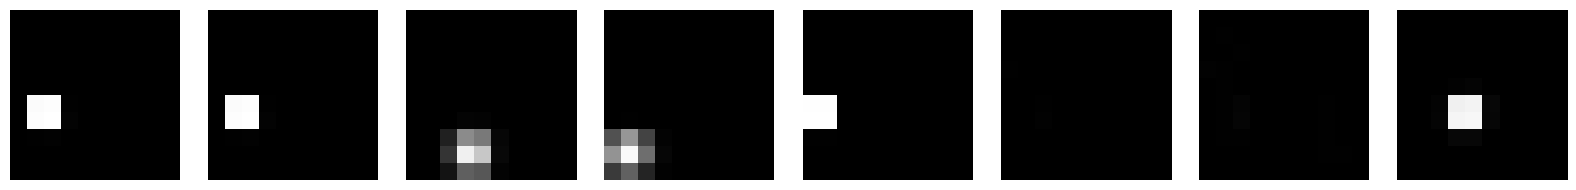

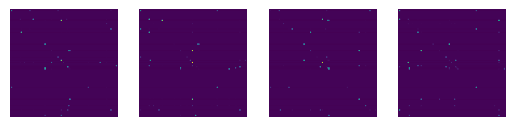

epoch 2400: 23.60


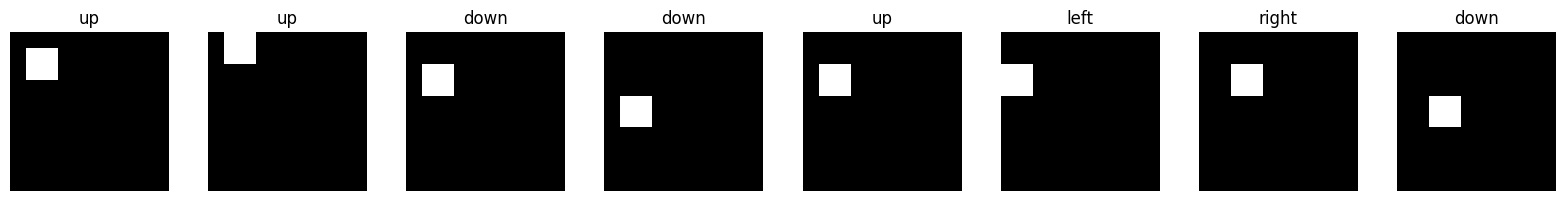

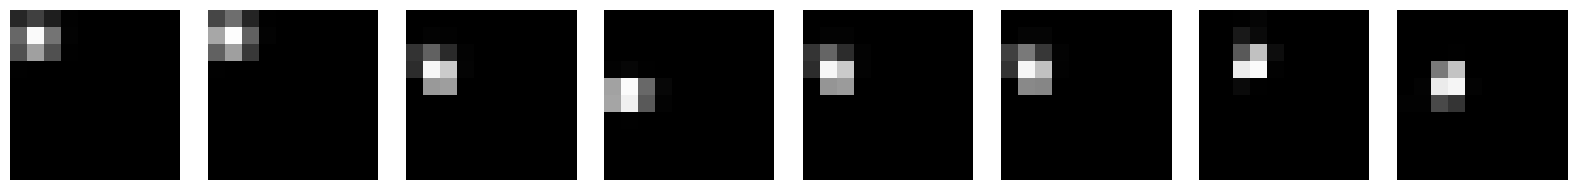

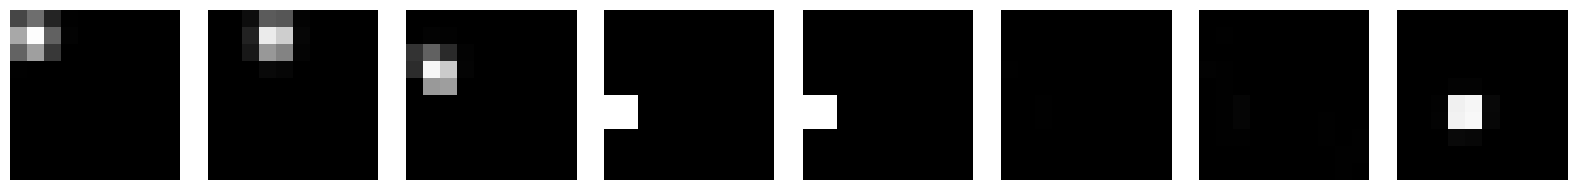

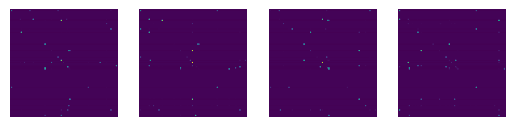

epoch 2500: 23.20


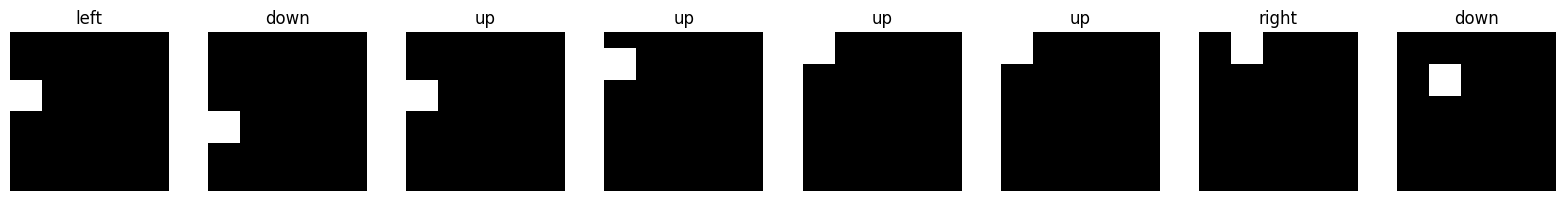

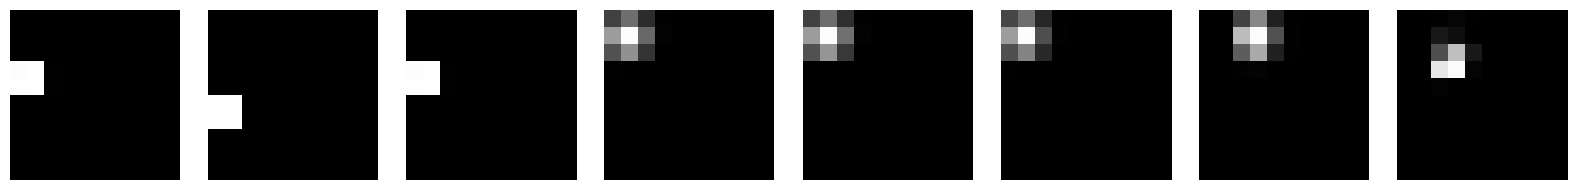

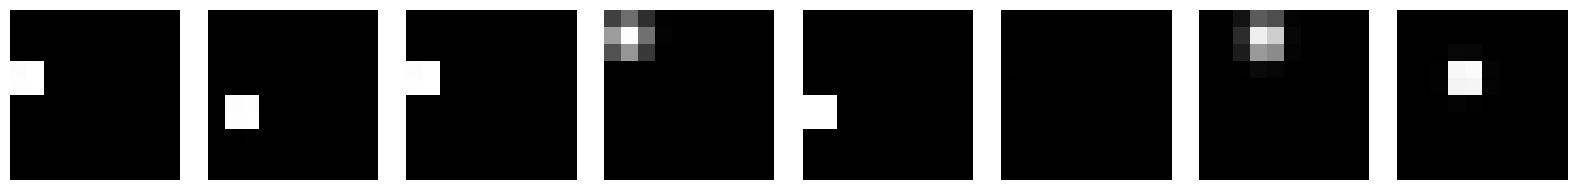

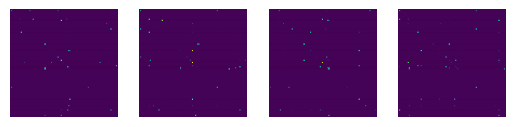

epoch 2600: 22.51


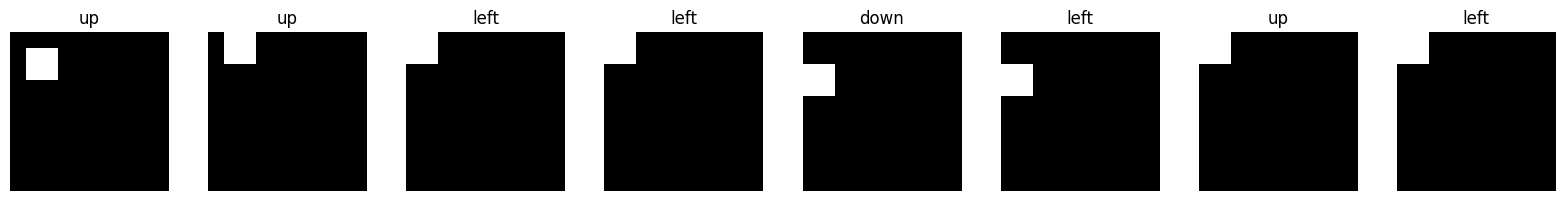

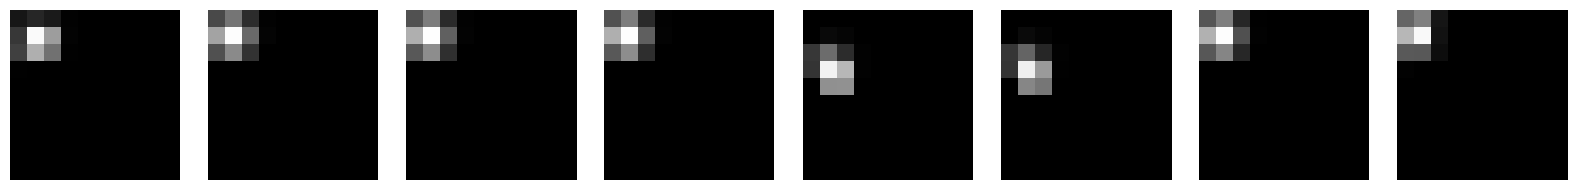

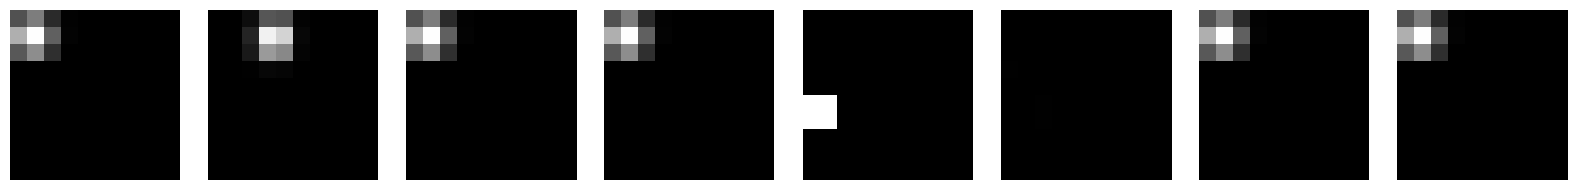

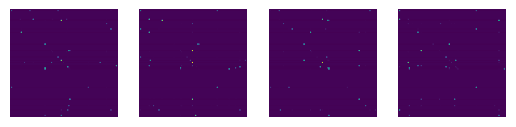

epoch 2700: 21.93


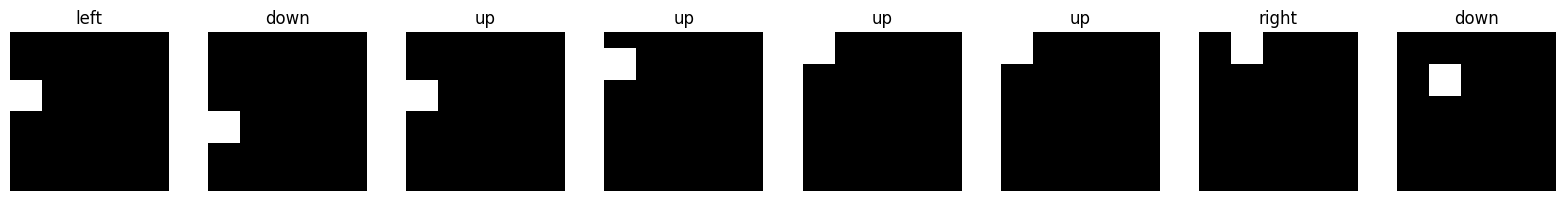

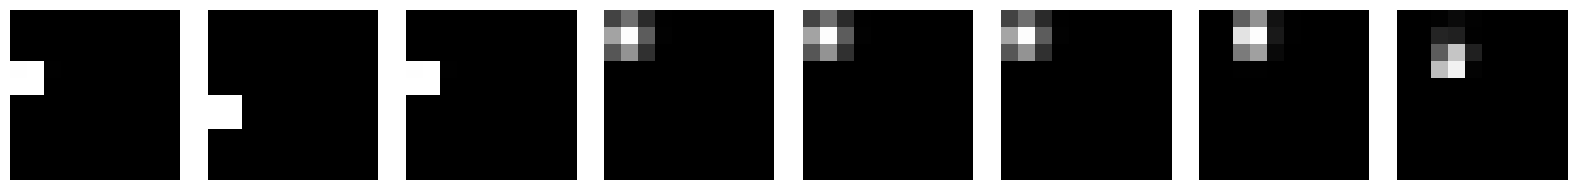

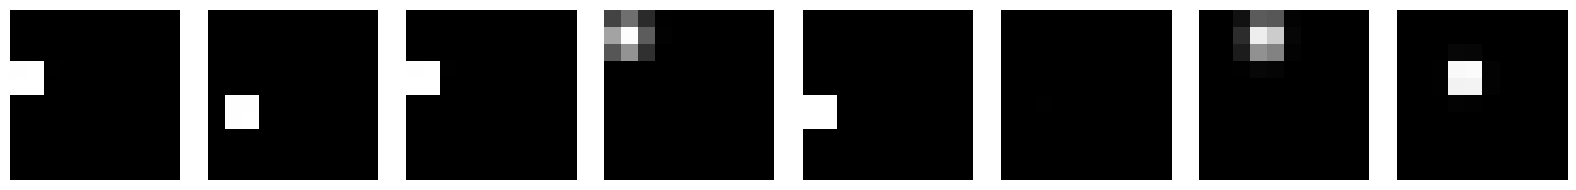

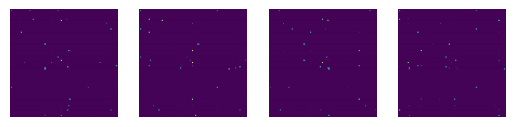

epoch 2800: 23.23


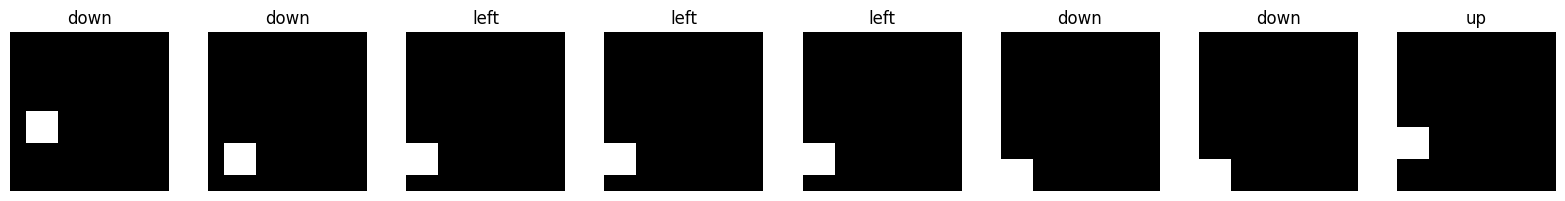

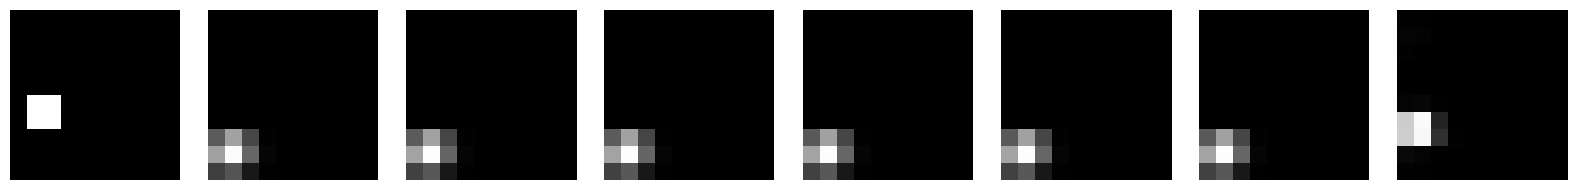

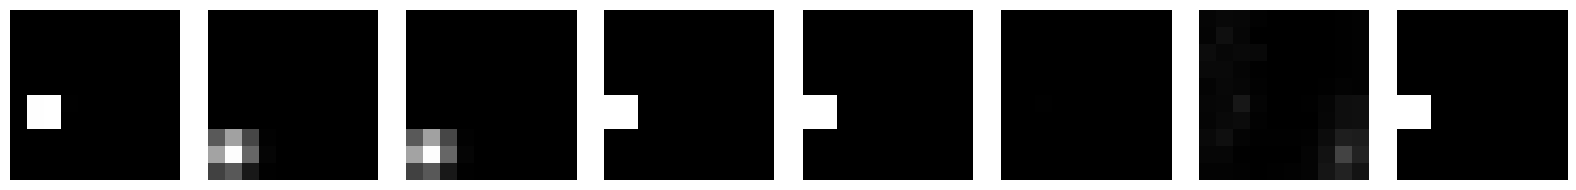

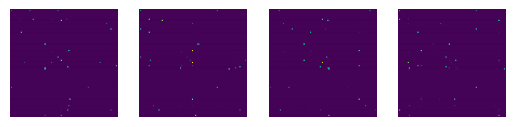

epoch 2900: 22.86


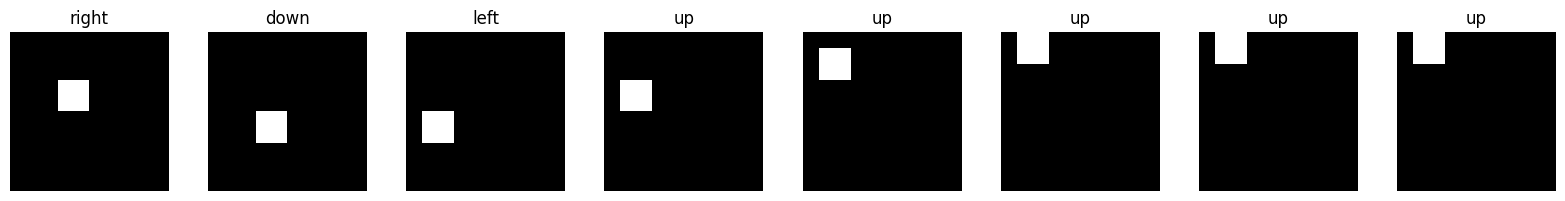

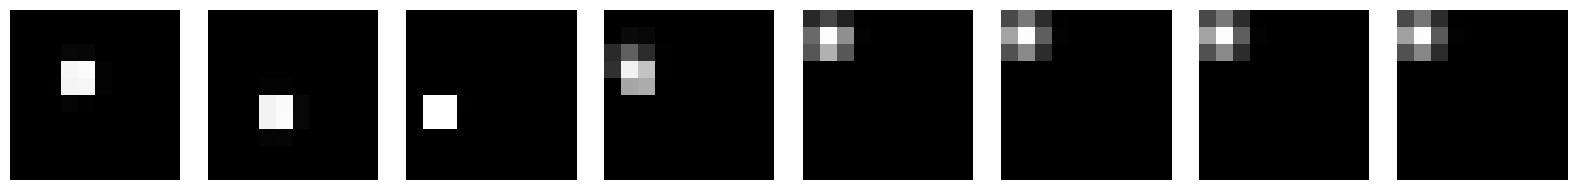

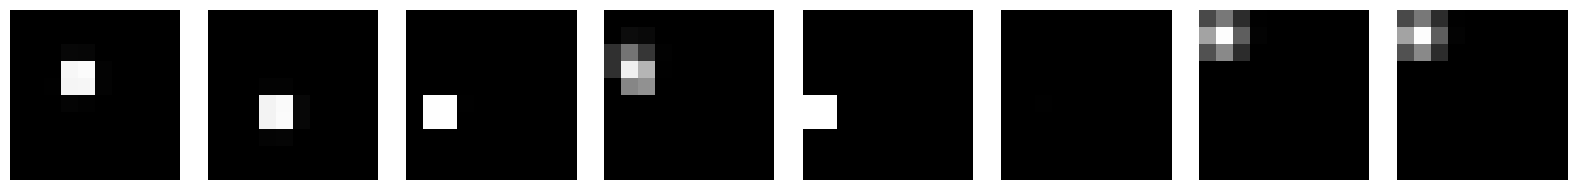

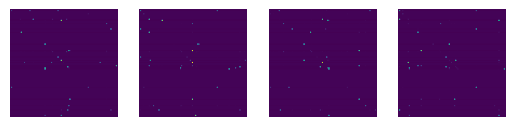

epoch 3000: 24.54


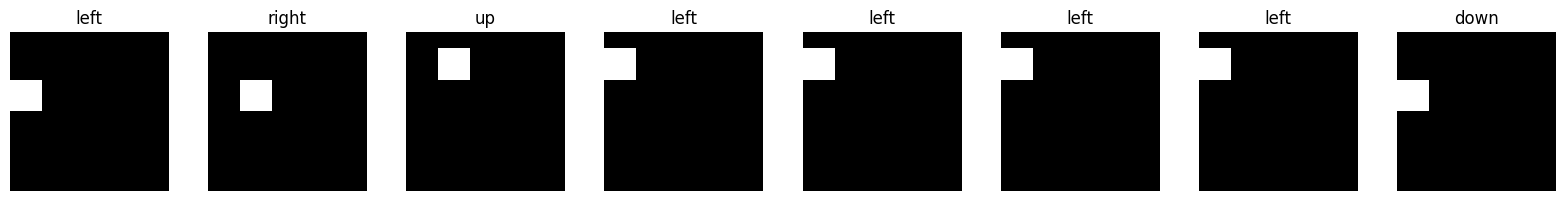

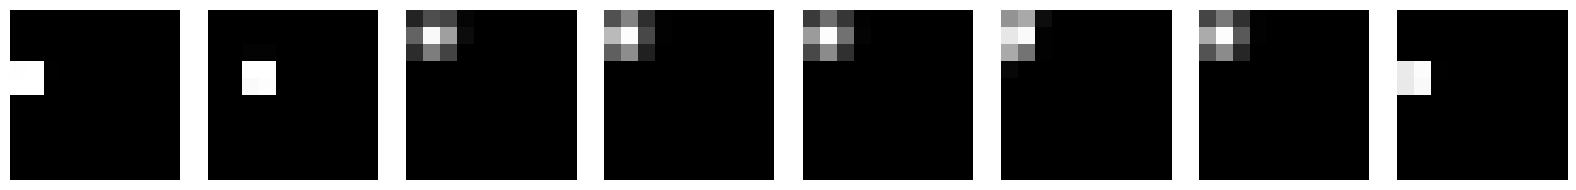

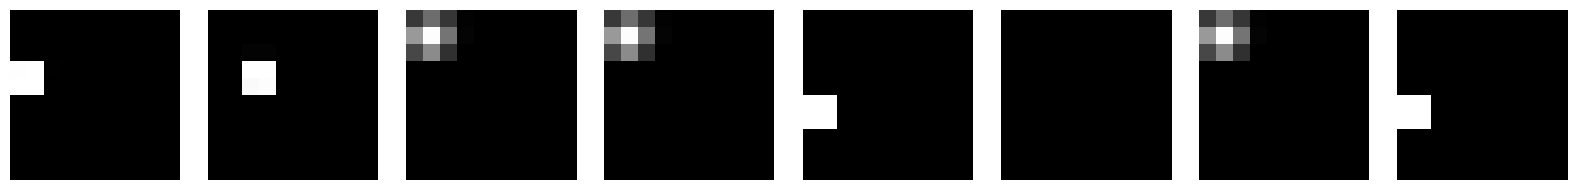

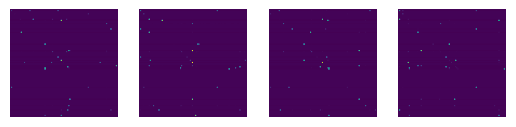

epoch 3100: 22.71


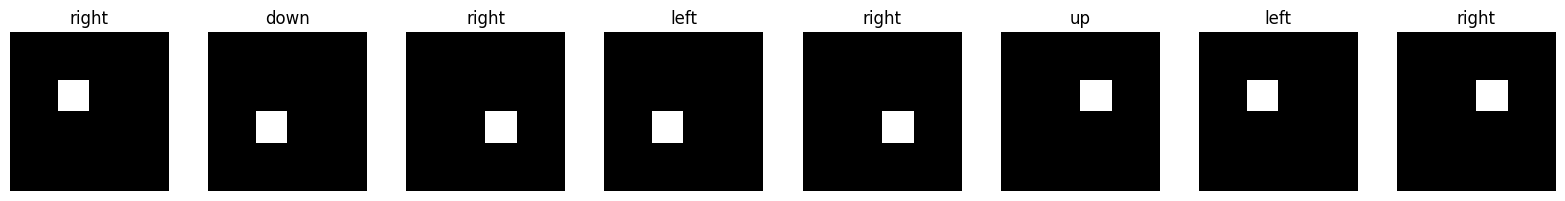

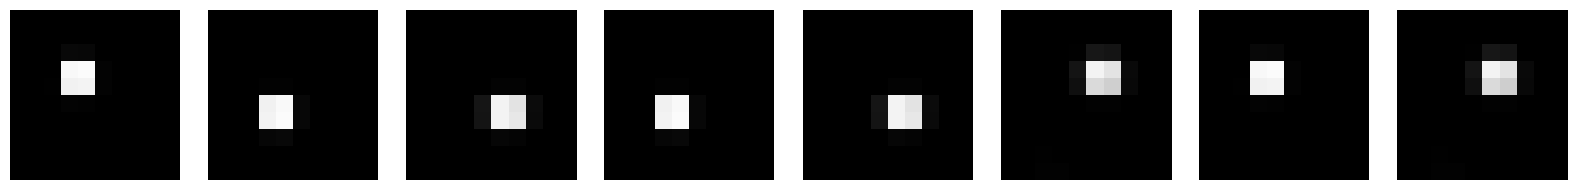

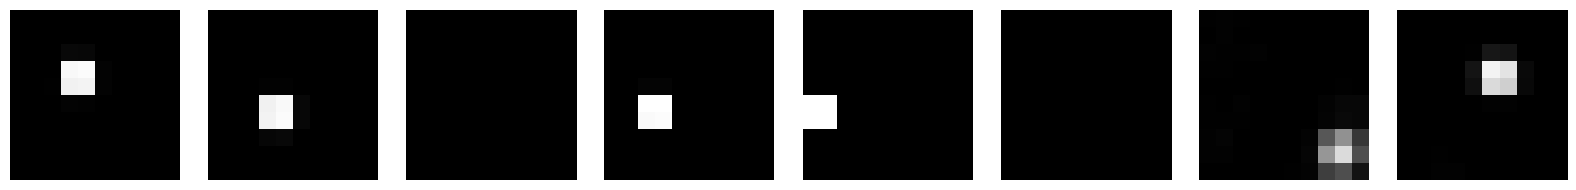

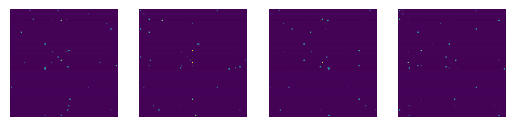

epoch 3200: 18.30


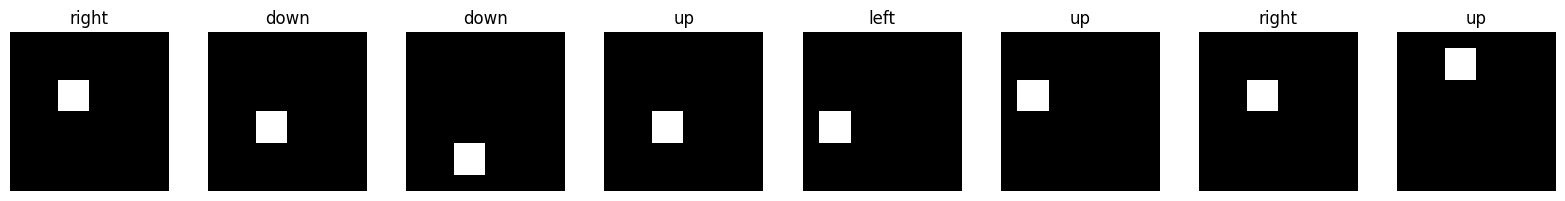

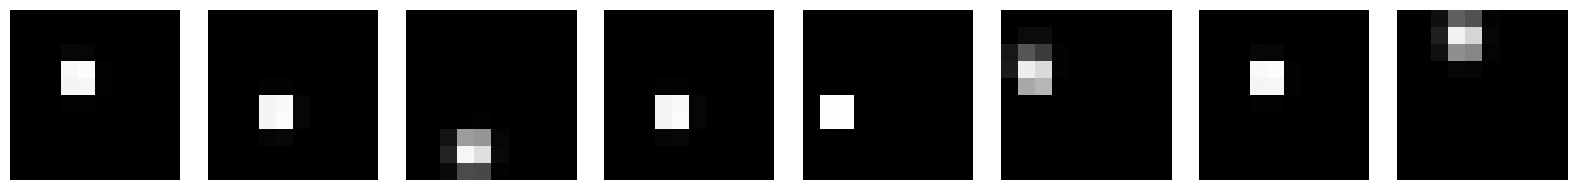

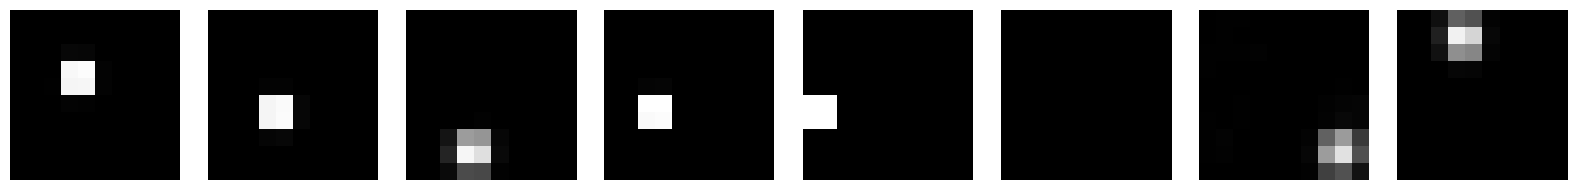

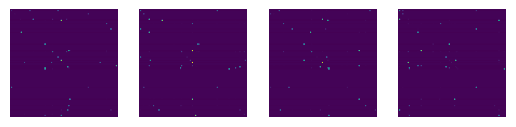

epoch 3300: 19.84


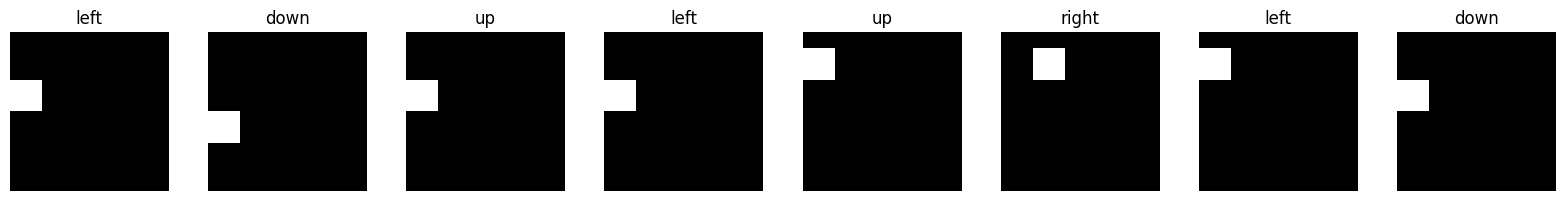

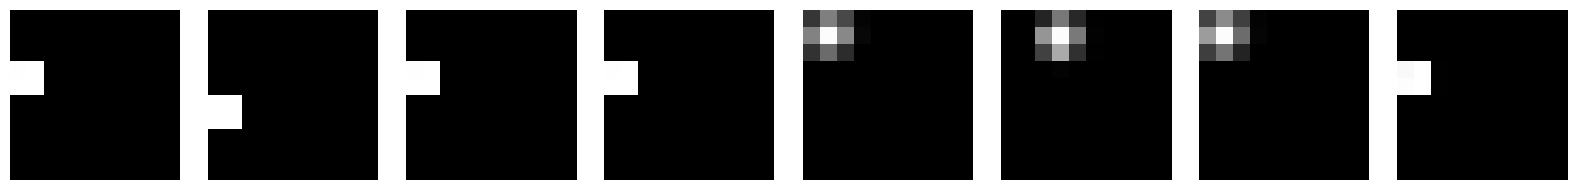

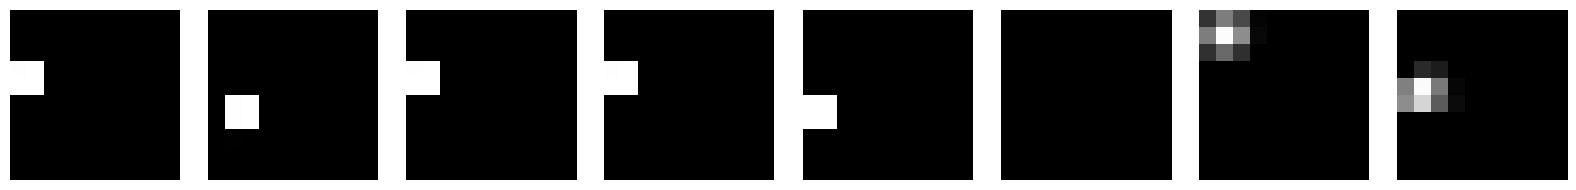

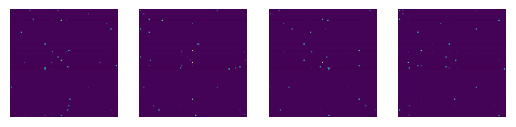

epoch 3400: 20.64


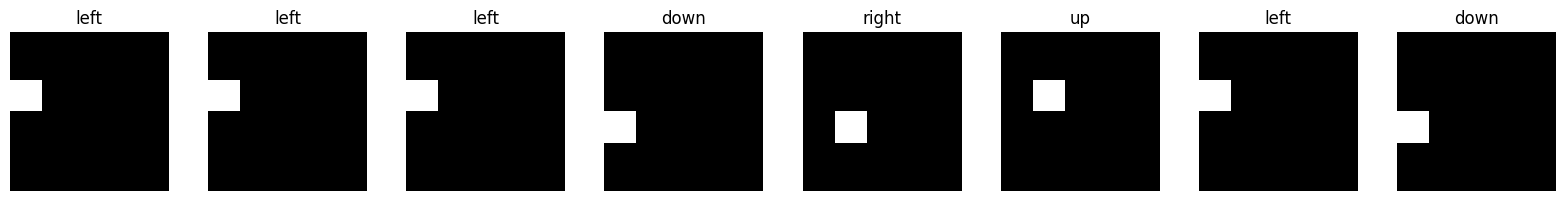

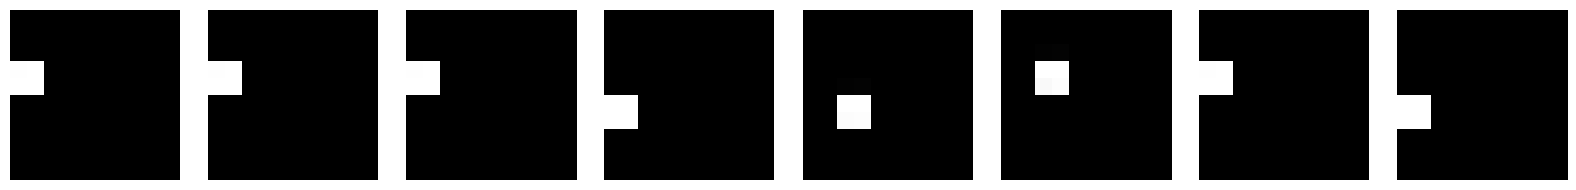

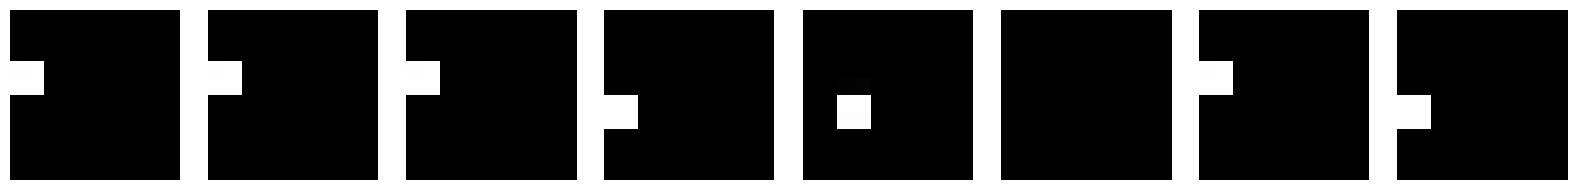

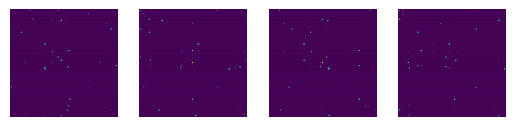

epoch 3500: 16.41


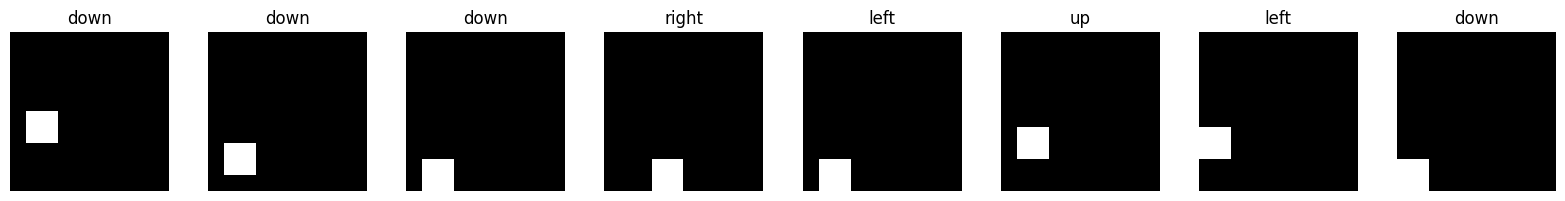

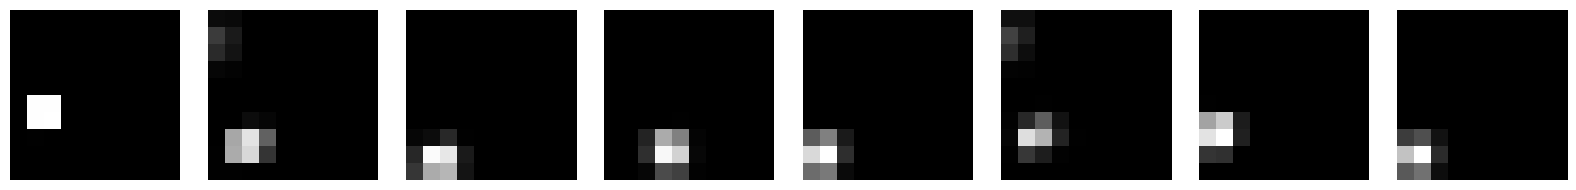

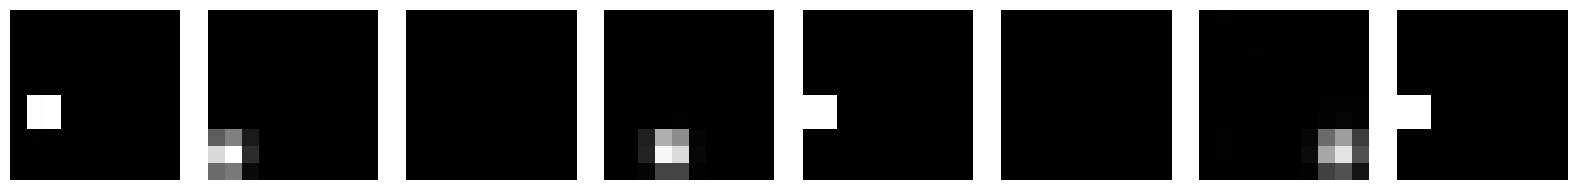

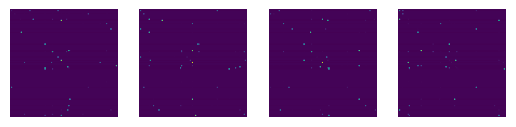

epoch 3600: 18.47


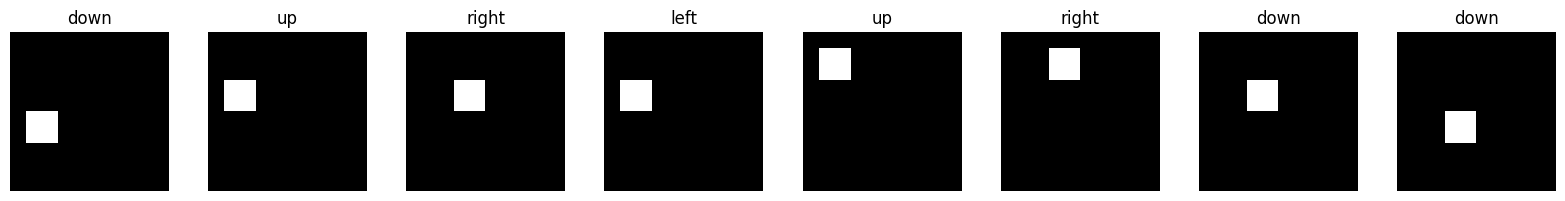

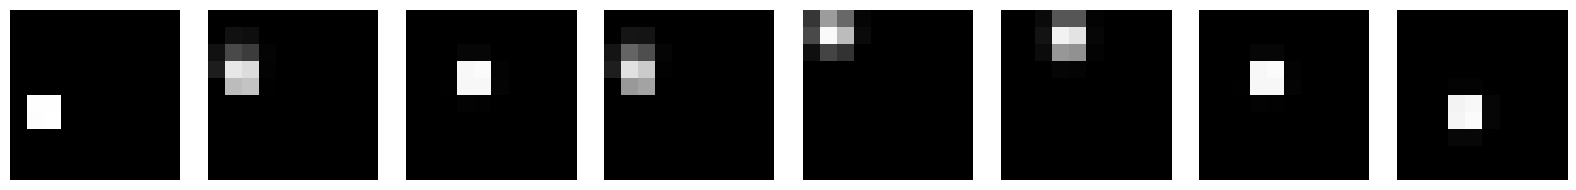

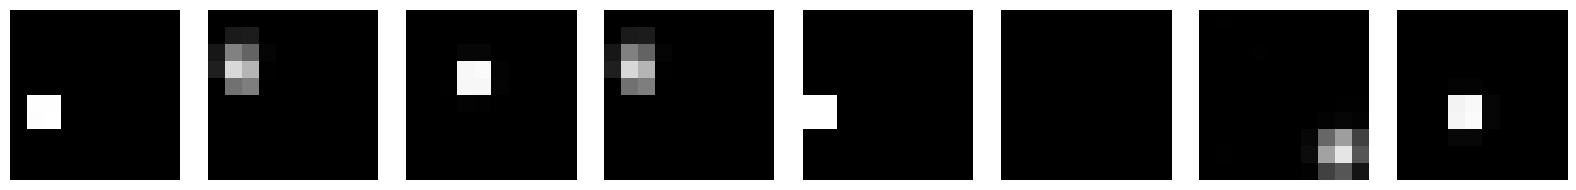

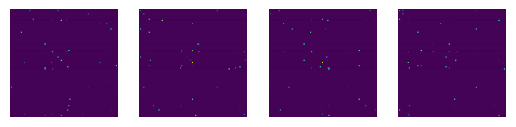

epoch 3700: 19.00


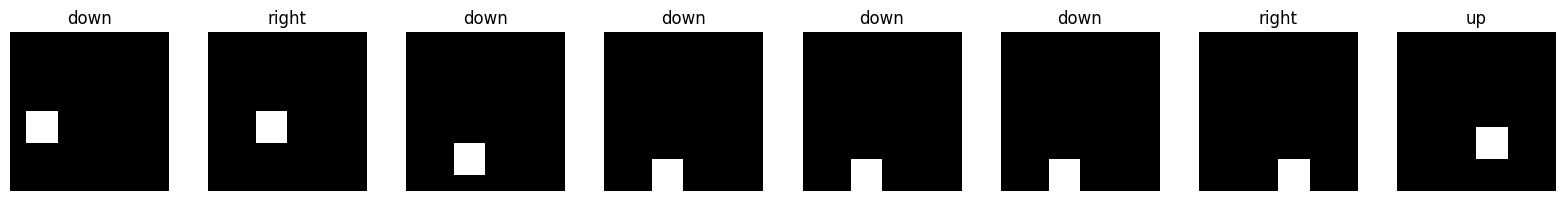

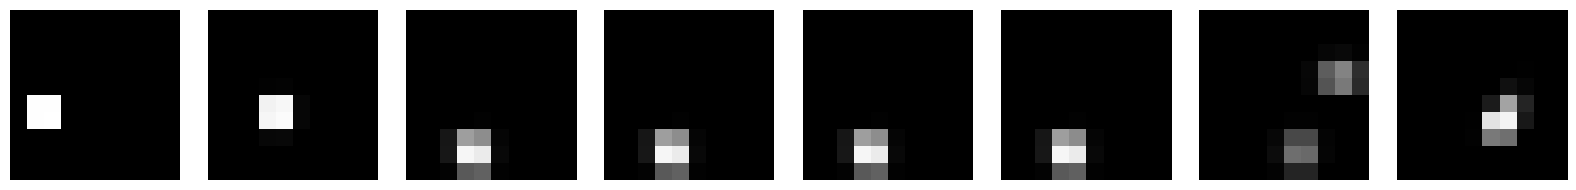

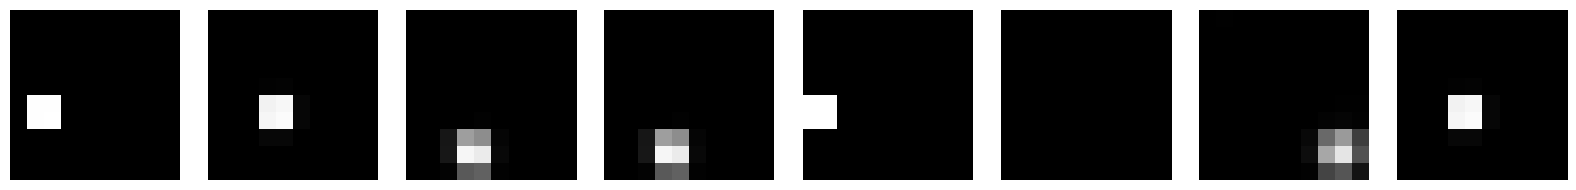

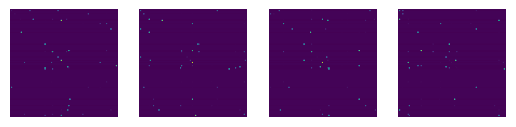

epoch 3800: 15.84


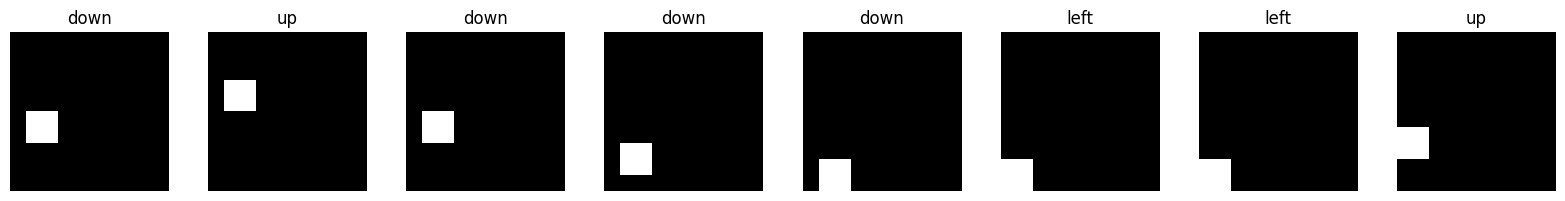

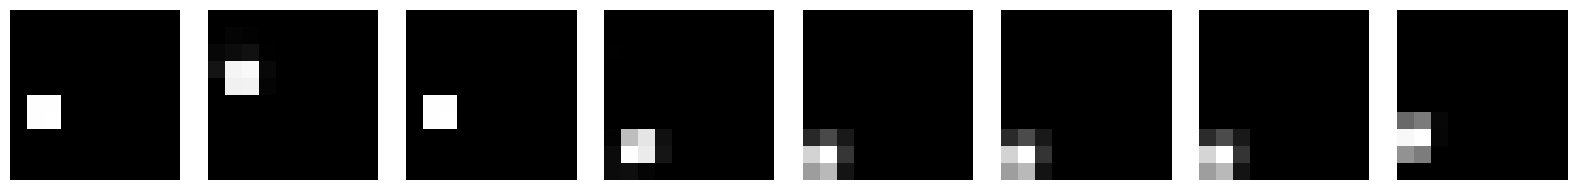

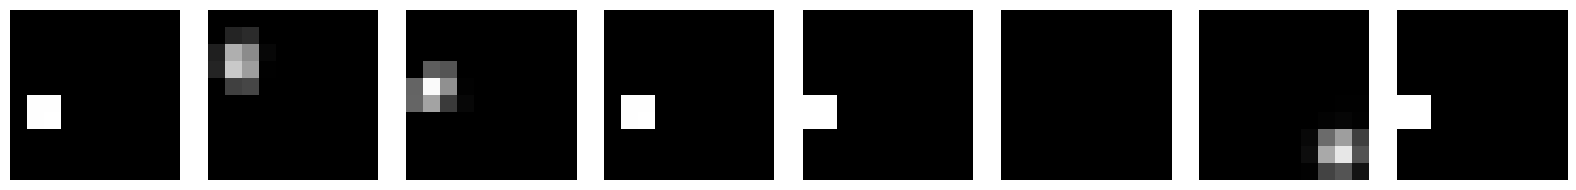

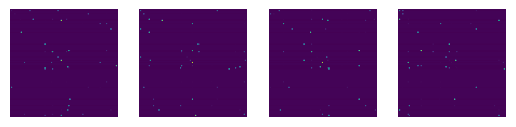

epoch 3900: 15.44


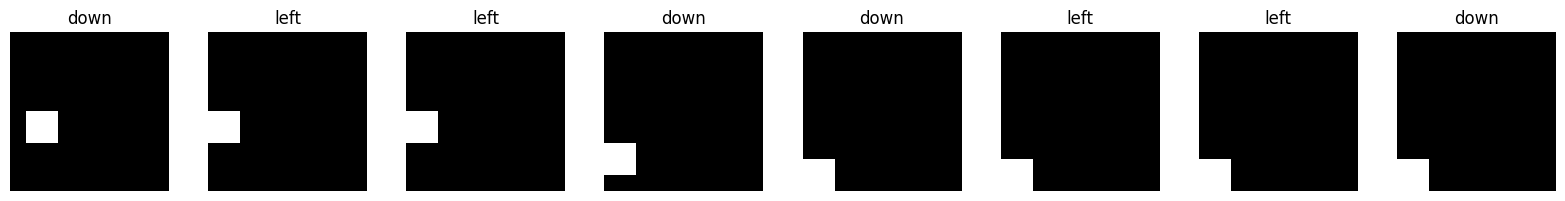

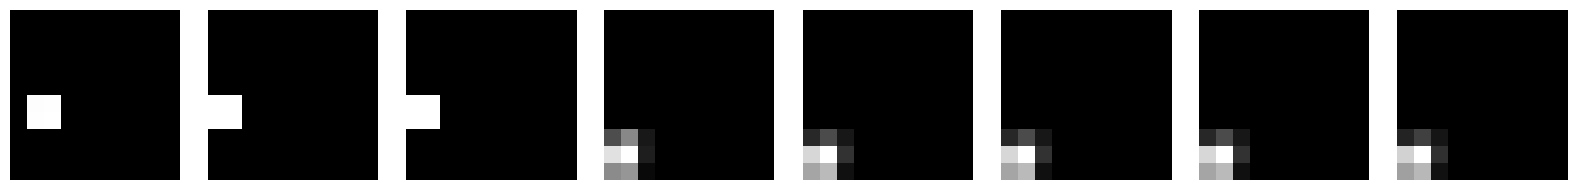

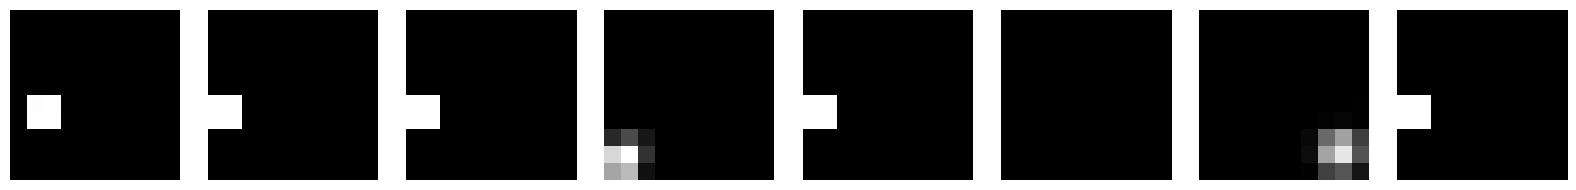

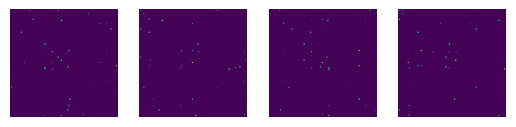

epoch 4000: 15.75


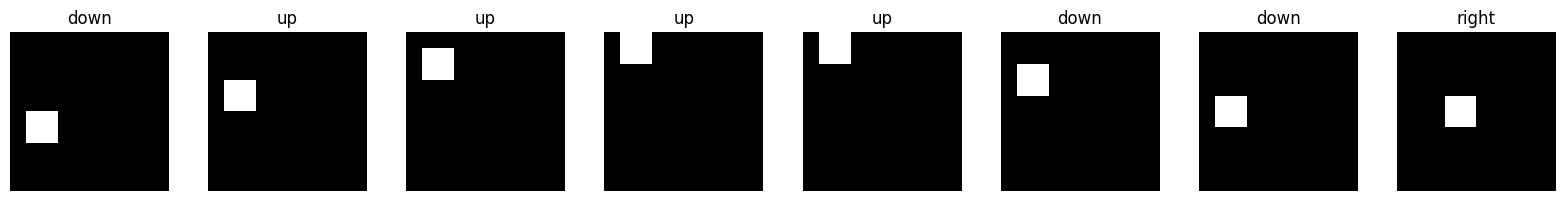

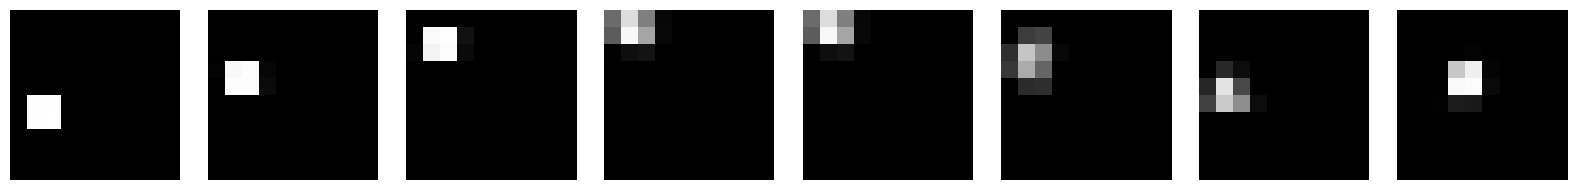

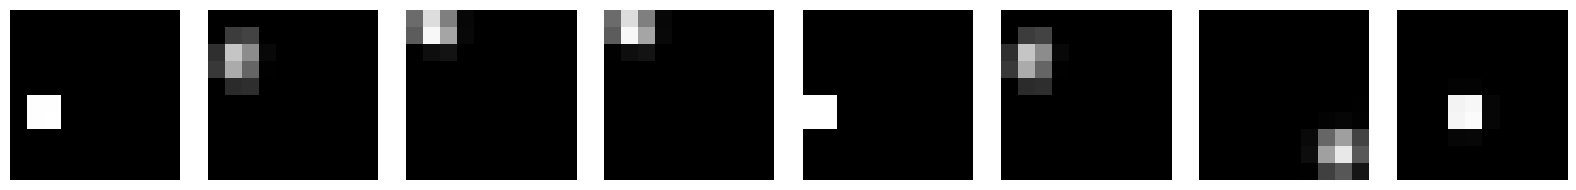

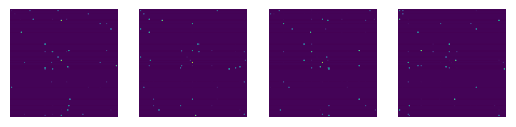

epoch 4100: 12.39


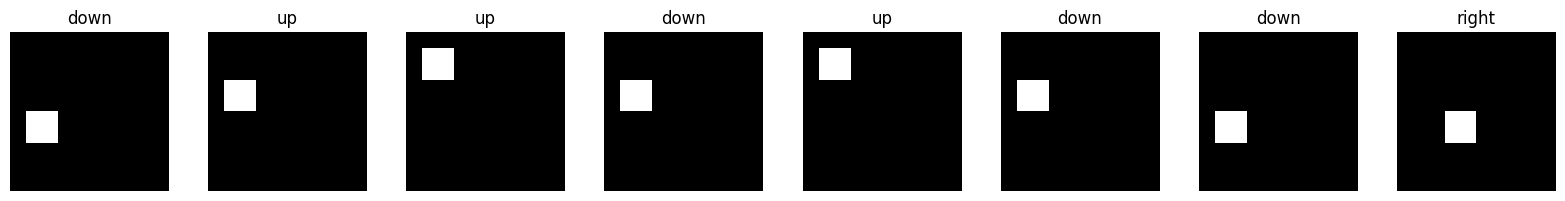

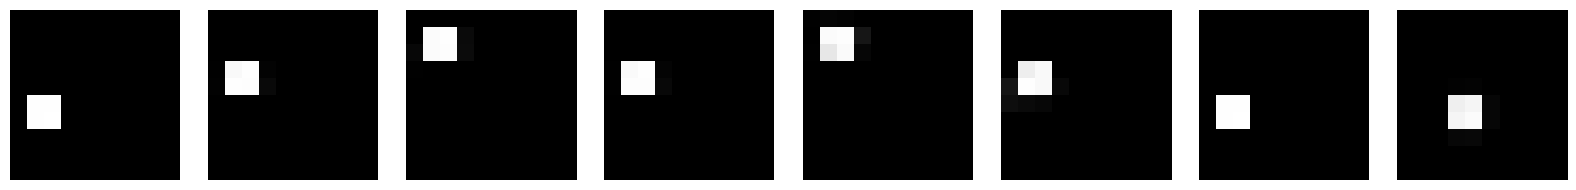

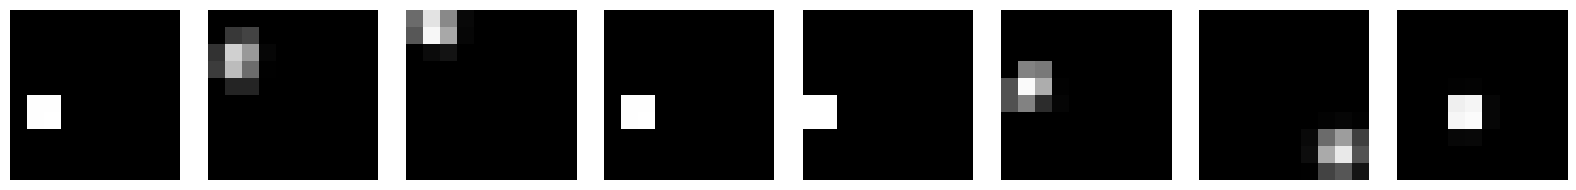

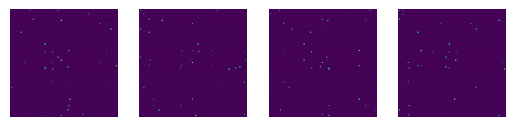

epoch 4200: 14.66


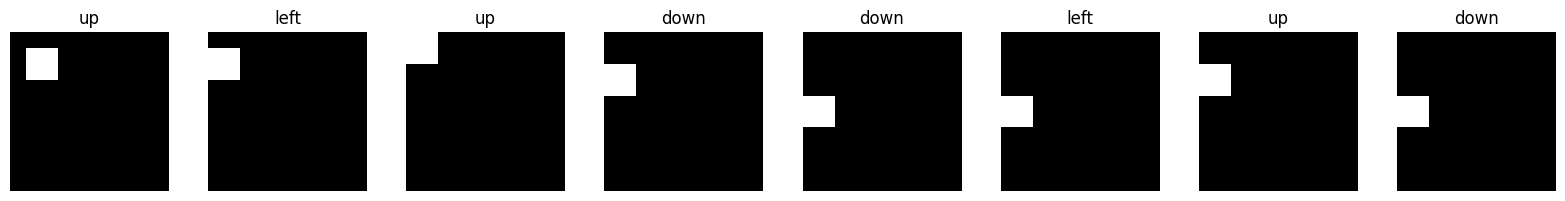

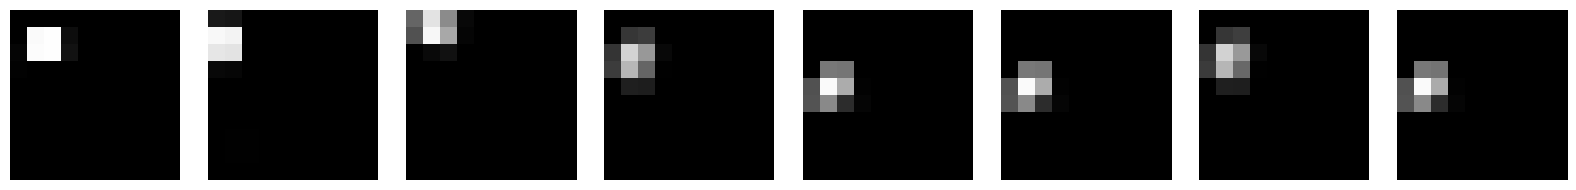

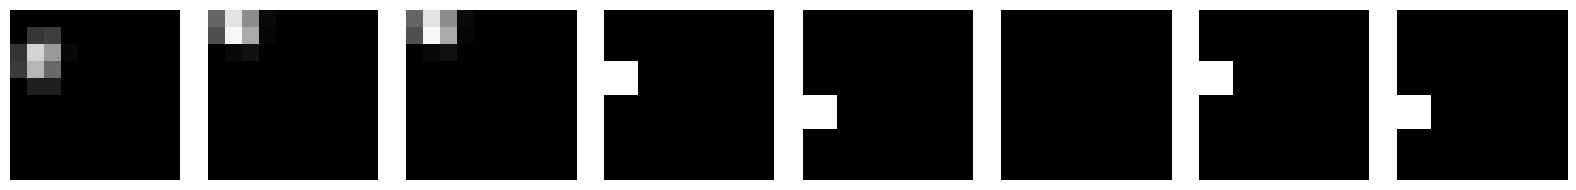

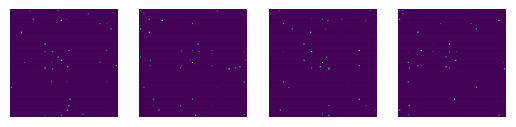

epoch 4300: 16.53


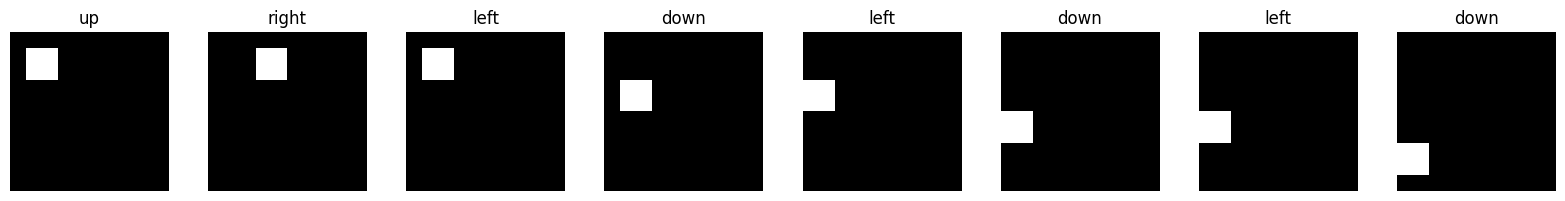

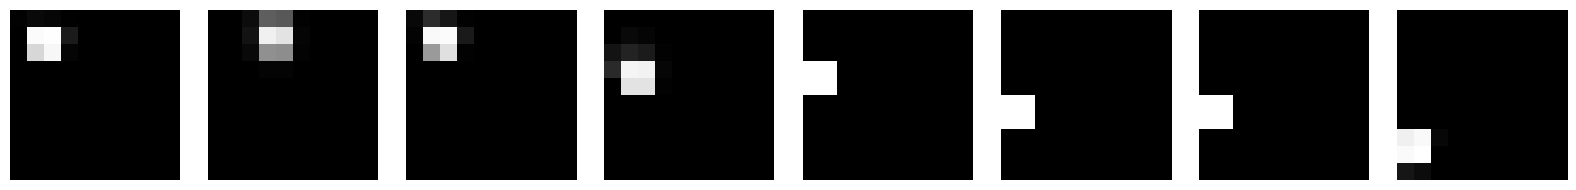

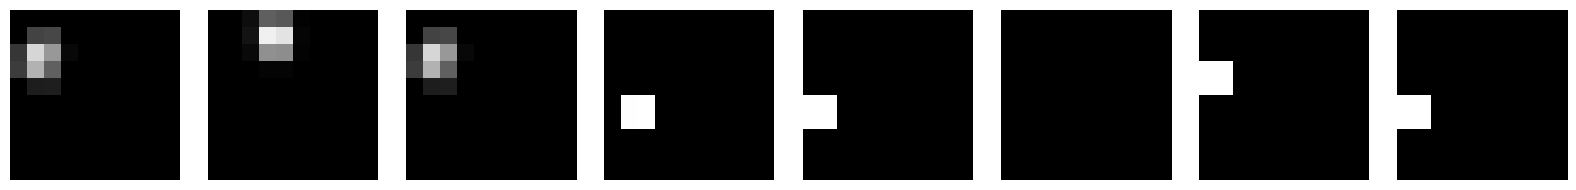

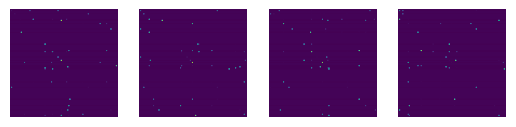

epoch 4400: 16.30


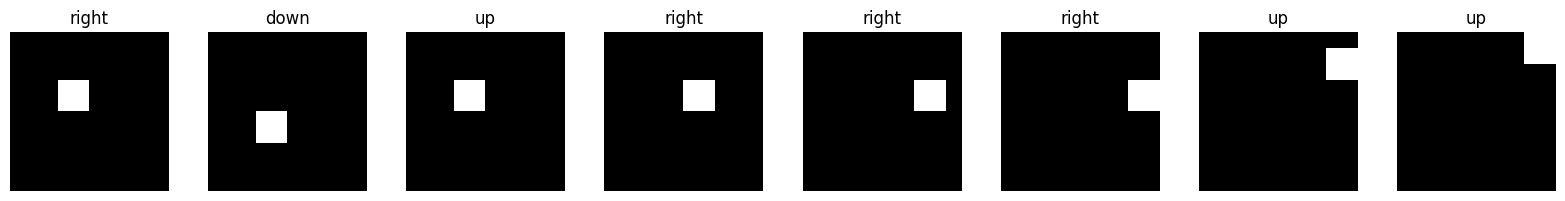

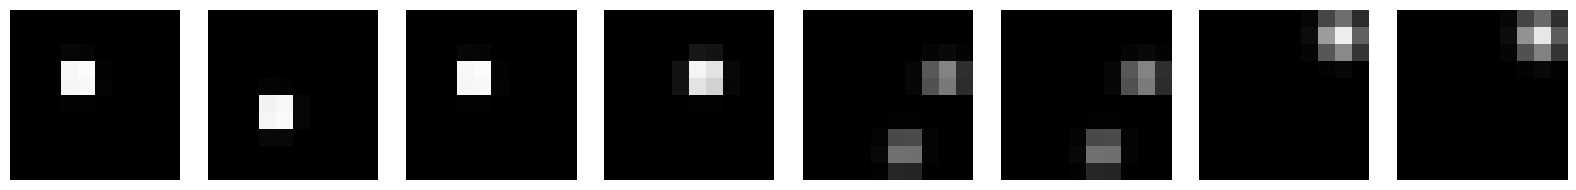

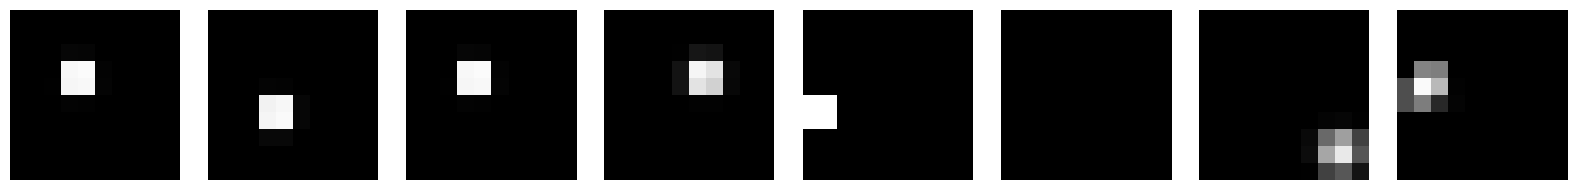

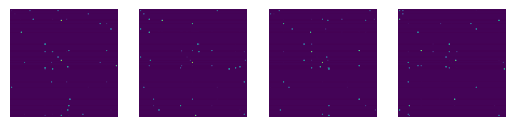

epoch 4500: 14.56


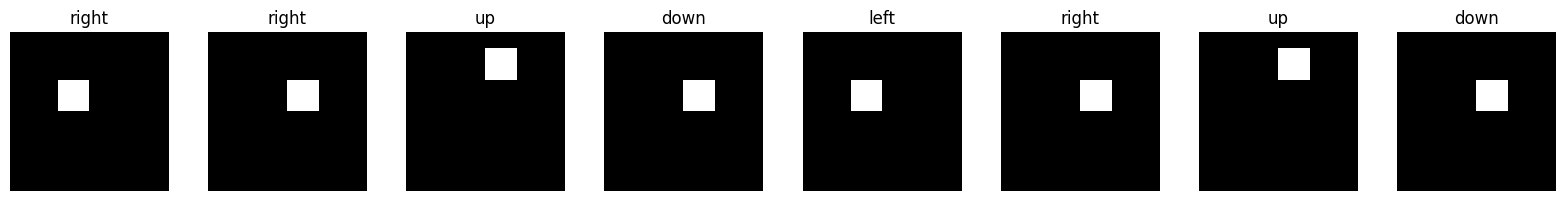

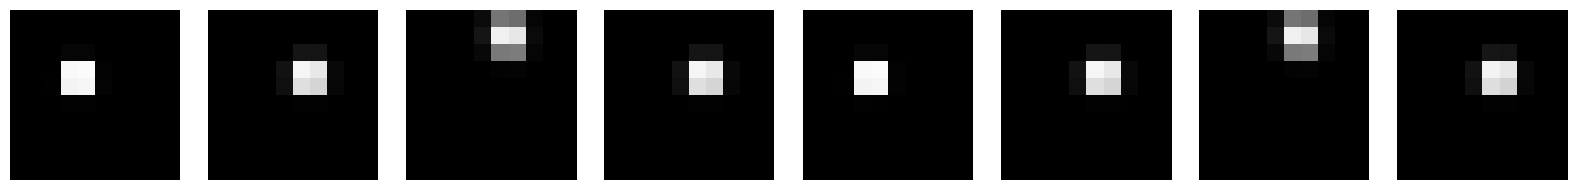

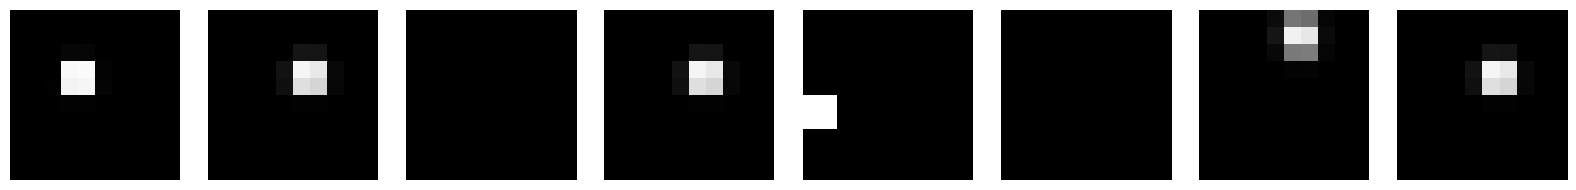

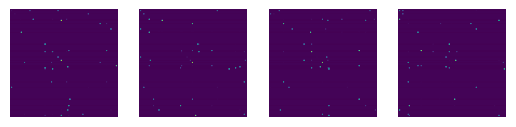

epoch 4600: 13.58


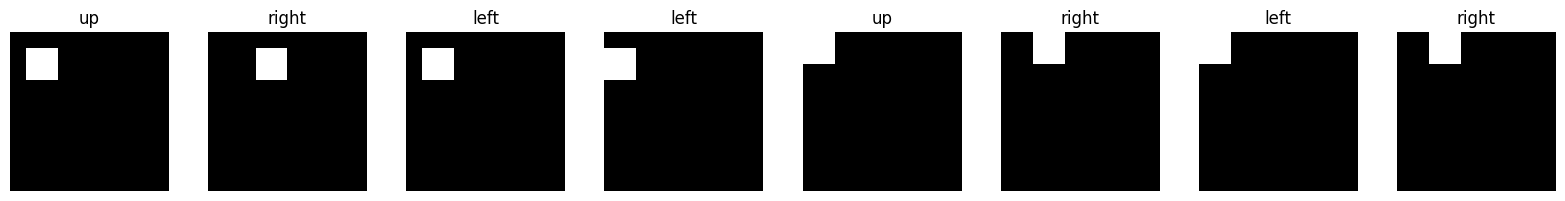

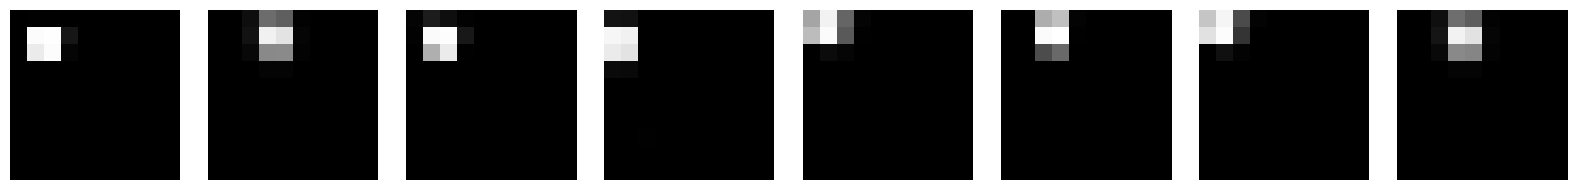

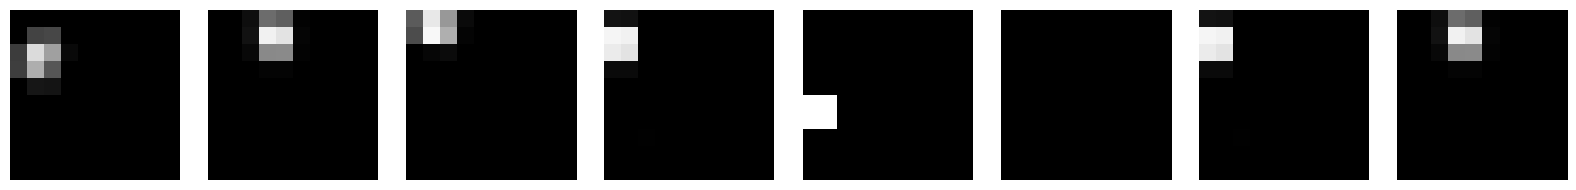

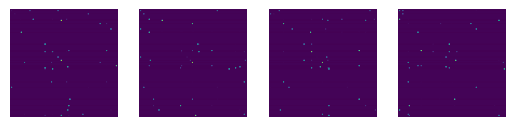

epoch 4700: 11.42


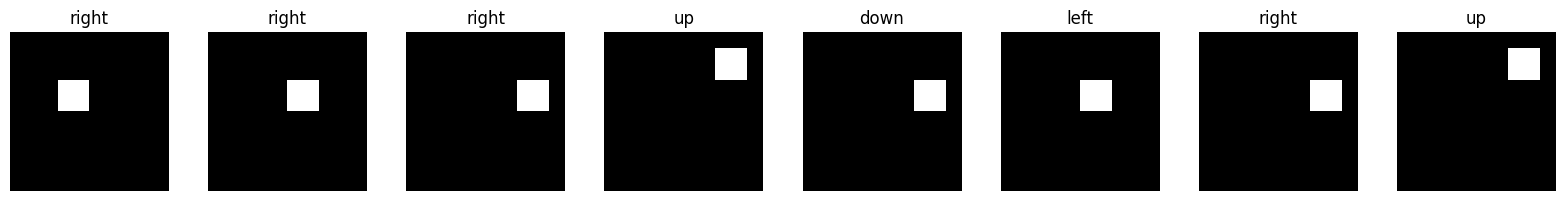

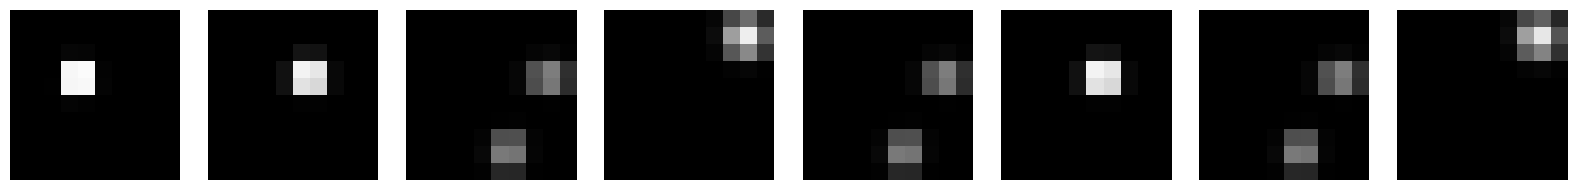

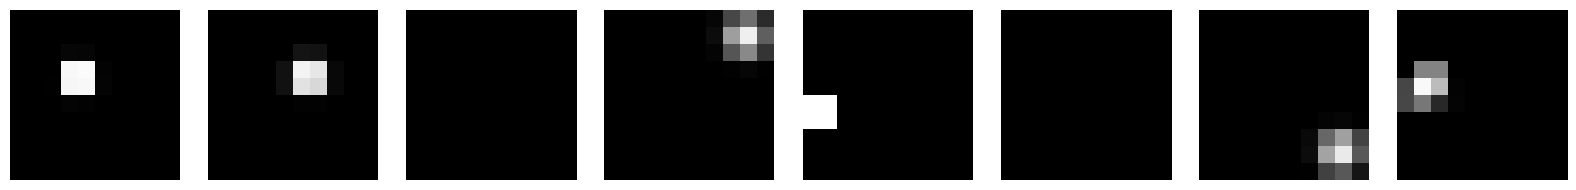

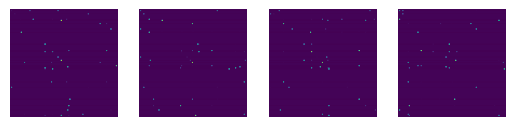

epoch 4800: 13.56


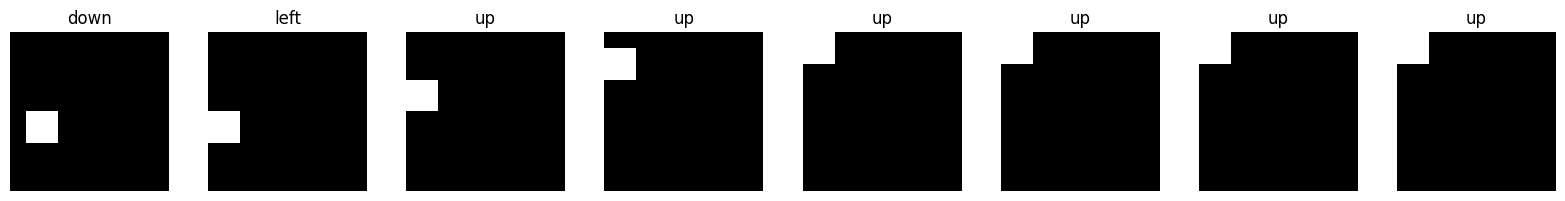

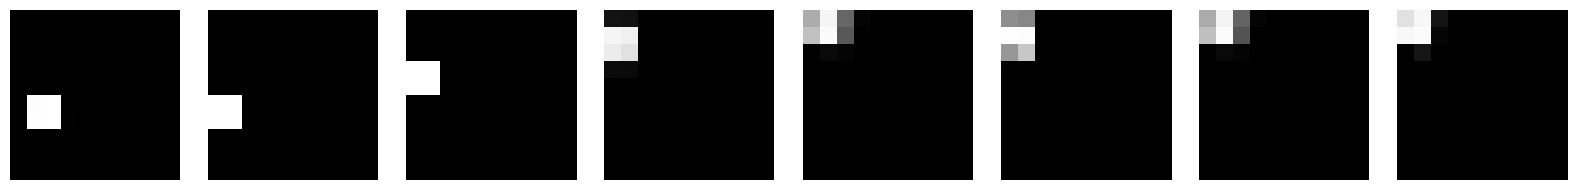

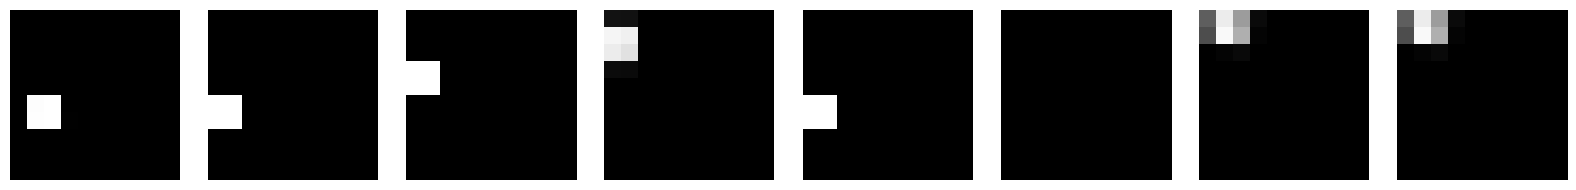

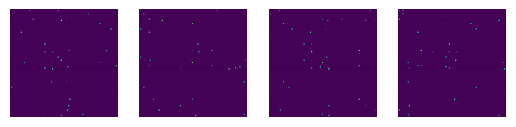

epoch 4900: 14.32


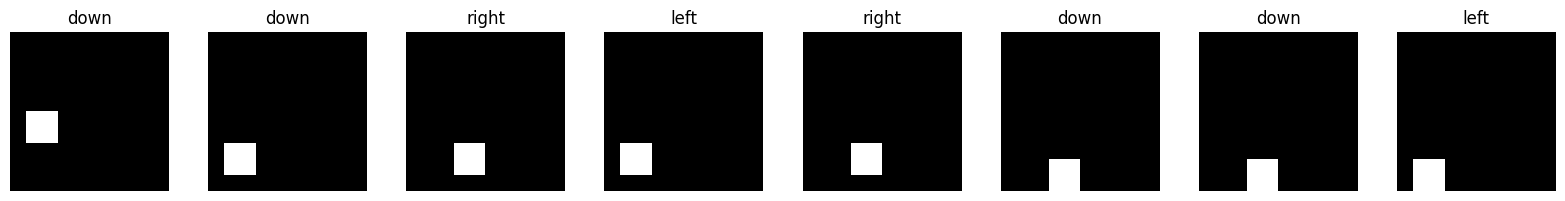

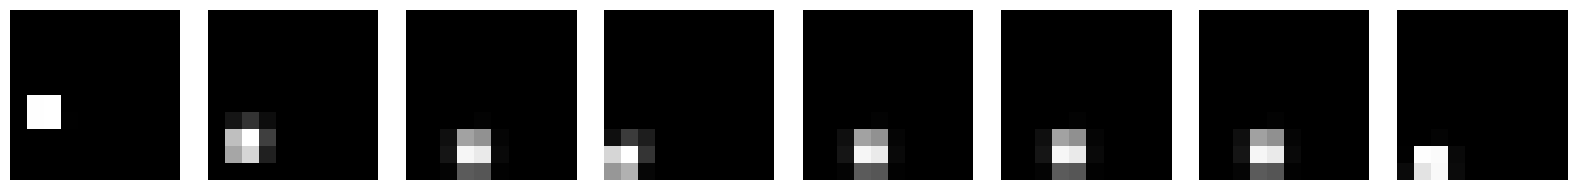

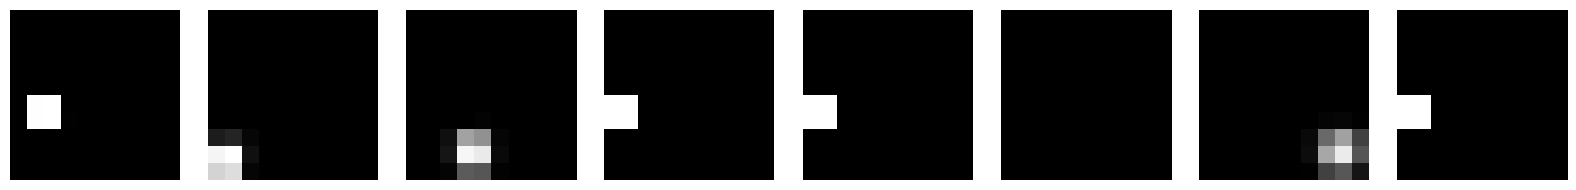

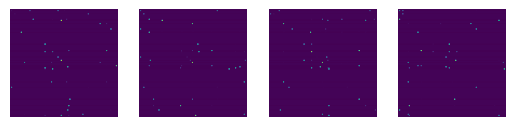

In [4]:
num_epochs = 5000
A, K, D = 4, 100, 100

prior_key, key = jr.split(key)
pgm_prior_params = init_pgm_param(prior_key, K, A, alpha=1.0)

encoder_key, key = jr.split(key)
encoder, encoder_params = init_mlp(encoder_key, D, [(512, jax.nn.relu), (K, identity)])

decoder_key, key = jr.split(key)
decoder, decoder_params = init_mlp(decoder_key, K, [(512, jax.nn.relu), (D, jax.nn.sigmoid)])
loglike = make_loglike(decoder)

pgm_key, key = jr.split(key)
pgm_params = init_pgm_param(pgm_key, K, A, alpha=1.0)

schedule = optax.linear_schedule(
    init_value=1e-3,
    end_value=1e-4,  
    transition_steps=num_epochs,  
)
nn_optim = optax.adamw(schedule)
nn_opt_state = nn_optim.init((decoder_params, encoder_params))


pgm_optim = optax.sgd(learning_rate=1e-3)
pgm_opt_state = pgm_optim.init(pgm_params)


grad_key, key = jr.split(key)
gradfun = make_gradfun(grad_key, run_inference, encoder, loglike, pgm_prior_params, 1, num_samples, num_batches, 1e4)

for epoch in range(num_epochs):
    (pgm_grads, decoder_grads, encoder_grads), elbo = gradfun((pgm_params, decoder_params, encoder_params), get_batch(epoch), get_action_batch(epoch))

    nn_updates, nn_opt_state = nn_optim.update((decoder_grads, encoder_grads), nn_opt_state, (decoder_params, encoder_params))
    (decoder_params, encoder_params) = optax.apply_updates((decoder_params, encoder_params), nn_updates)

    pgm_updates, pgm_opt_state = pgm_optim.update(pgm_grads, pgm_opt_state, pgm_params)
    pgm_params = optax.apply_updates(pgm_params, pgm_updates)

    if epoch % 100 == 0:
        print(f"epoch {epoch}: {elbo:.2f}")
        test((pgm_params, decoder_params, encoder_params), data, actions, env, key)